Import the required libraries

Retaining collection_recovery_fee because of analysis relevance even though 90 percentile is 00.0
total_rec_late_fee 90 percentile0.0
36    28287
60    10355
Name: term_in_months, dtype: int64
[15 13 14 16 12  0 11 10  9  8]


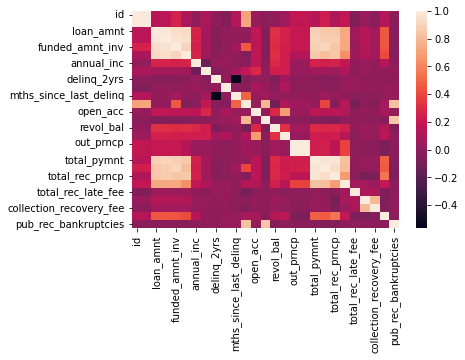

In [741]:
import pandas as pd
import math
import seaborn as sns
import warnings
import matplotlib as plt
warnings.filterwarnings("ignore")
#read the loan and dictionary files
loan = pd.read_csv("./data/loan.csv")
dictionary = pd.read_excel("./data/Data_Dictionary.xlsx")

#Data Cleaning

# dropping columns with only null values
loan = loan.drop(loan.columns[loan.isna().all()].tolist(),axis=1)
loan = loan[~(loan.emp_length.isnull())]

# dropping columns with a constant value
# 'acc_now_delinq','chargeoff_within_12_mths','delinq_amnt' have 0
# application_type has only 'individual'
# initial_list_status has only one value 'f'
# policy_code has only one value '1'
# pymnt_plan has only one value 'n'
loan = loan.drop(['acc_now_delinq','chargeoff_within_12_mths','delinq_amnt'],axis=1)
loan = loan.drop(['application_type'],axis=1)
loan = loan.drop(['initial_list_status','policy_code','pymnt_plan'],axis=1)
#[ 0. nan]
loan= loan.drop(['collections_12_mths_ex_med','tax_liens'],axis=1)

#Though the column collection_recovery_fee has quantile 0.9 is 0. It is relevant to the analysis hence retaining it
print("Retaining collection_recovery_fee because of analysis relevance even though 90 percentile is 0"+ str(loan.collection_recovery_fee.quantile(0.90)))

#loan = loan.drop(['collection_recovery_fee'],axis=1)
#Most of the loan was paid in time because late fee is 0 even in the 90 percentile
print("total_rec_late_fee 90 percentile"+str(loan.total_rec_late_fee.quantile(0.90)))

# drop text columns that are not relevant
loan = loan.drop(['desc','emp_title'],axis=1)

# finding out the columns with high correlation
sns.heatmap(loan.corr())

#loan amount is highly correlated with funded_amnt, funded_amnt_inv,installment
loan = loan.drop(['funded_amnt_inv','funded_amnt','installment'],axis=1)

#id and member_id are highly correlated dropping id as member_id is A unique LC assigned Id for the borrower member.
loan = loan.drop(['id'],axis=1)

#out_prncp_inv is highly corr to out_prncp
loan = loan.drop(['out_prncp_inv'],axis=1)

#total_rec_prncp is highly corr to total_pymnt_inv,total_pymnt
loan = loan.drop(['total_pymnt_inv','total_pymnt'],axis=1)

# id is the loan_id in the url. So dropping the url column
loan = loan.drop(['url'],axis=1)
# purpose and title have similar information 
loan = loan.drop(['title'],axis=1)
# state and zipcode first 3 characters are related. Dropping zipcode
loan = loan.drop(['zip_code'],axis=1)

# Type conversion
# Now we have to understand the remaining columns and ensure the data formats of the columns are as expected

# term's unique values are array([' 36 months', ' 60 months'], dtype=object). We can retain only the numbers and change the data type
loan.term = loan.term.str.lstrip(" ").str.rstrip(" months")
loan.term = loan.term.astype('int32')
loan.rename(columns = {'term':'term_in_months'}, inplace = True)
print(loan.term_in_months.value_counts())
# remove the % and convert to float
loan.int_rate = (loan.int_rate.apply(lambda x:x[:-1] if str(x).endswith("%") else x)).astype('float')
loan.revol_util = (loan.revol_util.apply(lambda x:x[:-1] if str(x).endswith("%") else x)).astype('float')

# Since emp_length does not have a 0 and is a numeric categorical data it is ok to have 0 for less than 1 year. 
loan.emp_length = (loan.emp_length.apply(lambda x:str(x).rstrip(" years").rstrip(" year")))
loan.emp_length = (loan.emp_length.apply(lambda x:"10" if str(x)=="10+" else x))
loan.emp_length = (loan.emp_length.apply(lambda x:"0" if str(x)=="< 1" else x)).astype('float')

loan['issue_year'] = (loan.issue_d.apply(lambda x:"20"+ x[-2:]))
loan.issue_year=loan.issue_year.fillna(loan.issue_year.mode()[0])
loan.issue_year = loan.issue_year.astype('int32')
loan['issue_month'] = (loan.issue_d.apply(lambda x:x[:-3]))
loan = loan.drop(['issue_d'],axis=1)

#When last payment date is not known, this is a candidate for charged off loans. So filling it with 0
loan.last_pymnt_d=loan.last_pymnt_d.fillna(0)
loan['last_pymnt_year'] = (loan.last_pymnt_d.apply(lambda x: str(x)[-2:]))
loan.last_pymnt_year = loan.last_pymnt_year.astype('int32')

loan['loan_in_years'] = loan['last_pymnt_year'] - loan['issue_year']
loan['last_pymnt_month'] = (loan.last_pymnt_d.apply(lambda x:str(x)[:-3]))
print(loan.last_pymnt_year.unique())
#loan = loan.drop(['last_pymnt_year'],axis=1)
#loan = loan.drop(['issue_year'],axis=1)
loan = loan.drop(['last_pymnt_d'],axis=1)

loan=loan[~loan.last_credit_pull_d.isnull()]
loan['last_credit_pull_year'] = (loan.last_credit_pull_d.apply(lambda x: str(x)[-2:]))
loan.last_credit_pull_year = loan.last_credit_pull_year.astype('int32')
loan['last_credit_pull_month'] = (loan.last_credit_pull_d.apply(lambda x:str(x)[:-3]))
loan = loan.drop(['last_credit_pull_d'],axis=1)

loan['earliest_cr_line'] = (loan.earliest_cr_line.apply(lambda x:x[-2:]).astype('int32'))
loan['earliest_cr_line'] = (loan.earliest_cr_line.apply(lambda x:x+2000 if x<30 else x+1900))

#Convert subgrade to number
loan.sub_grade = loan.sub_grade.str[-1]
loan.sub_grade = loan.sub_grade.astype('int32')

loan.inq_last_6mths = loan.inq_last_6mths.astype('int32')

# For analysis we will consider only `Fully Paid` and `Charged Off`
loan_for_analysis = loan[loan['loan_status'].isin(['Fully Paid','Charged Off'])]
loan_for_analysis = loan_for_analysis.drop(loan_for_analysis.columns[loan_for_analysis.isna().all()].tolist(),axis=1)

#out_prncp was hihgly correlated with everything, so removing it
loan_for_analysis = loan_for_analysis.drop(['out_prncp'],axis=1)


read the loan and dictionary files

last_credit_pull_year
7        36
8        41
9       228
10      839
11     2136
12     3971
13     5023
14     6012
15     5356
16    13900
Name: loan_amnt, dtype: int64 

last_credit_pull_month
Apr     4109
Aug     1974
Dec     2341
Feb     2995
Jan     2021
Jul     2000
Jun     1699
Mar     3208
May    10996
Nov     2147
Oct     2000
Sep     2052
Name: loan_amnt, dtype: int64 

pub_rec_bankruptcies
0.0    35311
1.0     1530
2.0        5
Name: loan_amnt, dtype: int64 

count    37542.000000
mean     11119.762533
std       7354.041563
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64


<AxesSubplot:>

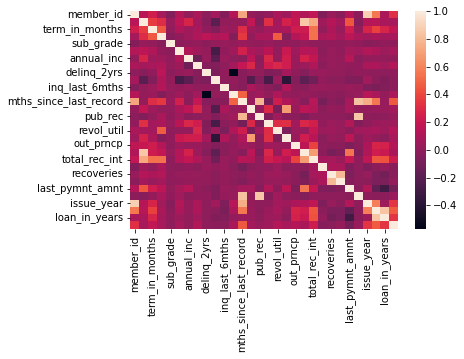

In [742]:
# There is a significant increase in 2016 LC pulled credit for loan
print(loan_for_analysis.groupby(by='last_credit_pull_year').count()['loan_amnt'],"\n")

# There is a significant increase in May LC pulled credit for loan
print(loan_for_analysis.groupby(by='last_credit_pull_month').count()['loan_amnt'],"\n")

# There are Approximately 1.5k public bankruptcies
print(loan_for_analysis.groupby(by='pub_rec_bankruptcies').count()['loan_amnt'],"\n")

# Derived variables to analyse data
# Loan status is computed as a number for analysis. Loan amnt is the weightage -1*loan_amnt if it is charged off, +1* loan_amnt if it is fully paid
loan_for_analysis['loan_status_num'] = loan_for_analysis.apply(lambda x:x['loan_amnt']*-1 if(x['loan_status']=='Charged Off') else x['loan_amnt'],axis=1)

#Most of the loans are taken by people with emp length <=5 or 10+
#loan_analysis = loan_analysis[(loan_analysis.emp_length<=5)|(loan_analysis.emp_length==10)]
# Higher the open_acc lower is the credit score
#loan_analysis = loan_analysis[loan_analysis.open_acc>10]
print(loan_for_analysis.describe()['loan_amnt'])

sns.heatmap(loan.corr())


In [743]:
#retaining only those records where pub_rec 
loan_for_analysis=loan_for_analysis[(~loan_for_analysis.pub_rec_bankruptcies.isnull())|((loan_for_analysis.pub_rec_bankruptcies.isnull())&(loan_for_analysis.pub_rec==0))]
loan_for_analysis.pub_rec_bankruptcies=loan_for_analysis.pub_rec_bankruptcies.fillna(0)
#pub_rec and pub_rec_bankruptcies have useful data for analysis when they are 0
loan_for_analysis[['pub_rec','pub_rec_bankruptcies','annual_inc','revol_bal','revol_util','total_acc']].describe()
loan_for_analysis.pub_rec.unique()
loan_for_analysis.pub_rec_bankruptcies.unique()
loan_for_analysis[loan_for_analysis.annual_inc.isnull()].count()['loan_status']
loan_for_analysis[loan_for_analysis.revol_bal.isnull()].count()['loan_status']
loan_for_analysis[loan_for_analysis.revol_util.isnull()].count()['loan_status']
loan_for_analysis[loan_for_analysis.total_acc.isnull()].count()['loan_status']

#Most of the values are 0 in pub_rec_bankruptcies. So filling it with 0
#loan_for_analysis.pub_rec_bankruptcies=loan_for_analysis.pub_rec_bankruptcies.fillna(0)
# It cannot be filled with most common value, hence filling it with 0
loan_for_analysis.mths_since_last_delinq=loan_for_analysis.mths_since_last_delinq.fillna(0)
loan_for_analysis.mths_since_last_delinq=loan_for_analysis.mths_since_last_delinq.astype('int')
# Since pub_rec for the records are 0 where mths_since_last_record is null. Setting the value to 0
loan_for_analysis.mths_since_last_record=loan_for_analysis.mths_since_last_record.fillna(0)
loan_for_analysis.mths_since_last_record=loan_for_analysis.mths_since_last_record.astype('int')
# to fill na of revol_util. When revol_bal==0, revol_util is set to zero. Since there is only one record of revol_bal not 0 when revol_util is nan, removing that record
loan_for_analysis.revol_util=loan_for_analysis.revol_util.fillna(0)
loan_for_analysis.revol_util=loan_for_analysis.revol_util.astype('int')
loan_for_analysis=loan_for_analysis[~(loan_for_analysis.revol_util.isnull()&(loan_for_analysis.revol_bal!=0))]

#Cannot derive revol_util from revol_bal. Cannot set it to the mode of the column as it doesn't make sense functionally. 
#So slicing those rows that have revol_util as Nan
loan_for_analysis = loan_for_analysis[~loan_for_analysis.revol_util.isnull()]
loan_for_analysis = loan_for_analysis[loan_for_analysis.annual_inc<=9.000000e+04]

In [744]:
def printDiffFullyPaidAndChargedOff(df):
    total_chr_off = df[df.loan_status=='Charged Off'].loan_amnt.sum()
    total_fully_paid = df[df.loan_status=='Fully Paid'].loan_amnt.sum()

    print("Total fully paid loan amount in slice "+ str(total_fully_paid))
    print("Total charged off loan amount in slice "+ str(total_chr_off))
    print("The difference between fully paid and charged off "+ str(total_fully_paid-total_chr_off))
    print("\n")

def printCreditLossInSlice(condition,xAsisLabel,df):
    #Finding the total charged off amount
    #Finding the total charged off amount when condition
    cr_off = df[condition]
    sns.boxplot(data=cr_off, x=xAsisLabel, y='loan_status')
    cr_loss = cr_off.loan_amnt.sum()

    #print("Condtion on "+ condition.name)
    printDiffFullyPaidAndChargedOff(cr_off)
    
def home_ownership_notNONE(df): 
    return (~df.home_ownership.isin(['NONE']))


In [745]:
# To find the driving Factors
# Categorising continuous variables for better comparison
loan_for_analysis['dti_cat']= pd.qcut(loan_for_analysis.dti,  5, labels=["Low","Below Avg","Avg","Above Avg","High"])
loan_for_analysis['int_rate_cat']= pd.qcut(loan_for_analysis.int_rate,  5, labels=["Low","Below Avg","Avg","Above Avg","High"])
loan_for_analysis['annual_income_cat']= pd.qcut(loan_for_analysis.annual_inc,  5, labels=["Low","Below Avg","Avg","Above Avg","High"])
loan_for_analysis['revol_bal_cat']= pd.qcut(loan_for_analysis.revol_bal,  5, labels=["Low","Below Avg","Avg","Above Avg","High"])
loan_for_analysis['revol_util_cat']= pd.qcut(loan_for_analysis.revol_util,  5, labels=["Low","Below Avg","Avg","Above Avg","High"])
loan_for_analysis['total_acc_cat']= pd.qcut(loan_for_analysis.total_acc,  5, labels=["Low","Below Avg","Avg","Above Avg","High"])
loan_for_analysis['grade_subgrade'] = loan_for_analysis.apply(lambda x:x.grade+str(x.sub_grade), axis=1)

def boxsubplot(axes,df,xaxisParameter,yaxisParameter,hueParameter):
    sns.boxplot(ax=axes,data=df, x=xaxisParameter, y=yaxisParameter,hue=hueParameter)
    axes.set_title(xaxisParameter)
    axes.tick_params(axis='both', which='both', labelsize=7, labelbottom=True)

def plotToChooseDrivingFactorCategorical(df):
    fig, axes = plt.pyplot.subplots(3, 4, figsize=(50, 25),sharey=True)
    fig.suptitle('Finding Categorical Driving Factors')

    boxsubplot(axes[0,0],df,'home_ownership','loan_amnt','loan_status')
    boxsubplot(axes[0,1],df, 'term_in_months', 'loan_amnt',"loan_status")
    boxsubplot(axes[0,2],df, 'sub_grade', 'loan_amnt',"loan_status")
    boxsubplot(axes[0,3],df, 'verification_status', 'loan_amnt',"loan_status")    
    boxsubplot(axes[1,0],df, 'purpose', 'loan_amnt',"loan_status")
    axes[1,0].tick_params(axis='x', rotation=90)
    boxsubplot(axes[1,1],df, 'emp_length', 'loan_amnt',"loan_status")
    boxsubplot(axes[1,2],df, 'addr_state', 'loan_amnt',"loan_status")
    axes[1,2].tick_params(axis='x', rotation=90)
    boxsubplot(axes[1,3],df, 'grade', 'loan_amnt',"loan_status")
    boxsubplot(axes[2,0],df,'last_pymnt_month','loan_amnt','loan_status')
    boxsubplot(axes[2,1],df, 'last_credit_pull_month', 'loan_amnt',"loan_status")
    boxsubplot(axes[2,2],df, 'issue_month', 'loan_amnt',"loan_status")

def plotToChooseDrivingFactorDerivedCategorical(df):
    fig, axes = plt.pyplot.subplots(3, 3, figsize=(50, 25),sharey=True)
    fig.suptitle('Finding Derived Categorical Driving Factors')

    boxsubplot(axes[0,0],df, 'dti_cat', 'loan_amnt',"loan_status")
    boxsubplot(axes[0,1],df, 'int_rate_cat', 'loan_amnt',"loan_status")
    boxsubplot(axes[0,2],df, 'annual_income_cat', 'loan_amnt',"loan_status")
    boxsubplot(axes[1,0],df, 'revol_bal_cat', 'loan_amnt',"loan_status")    
    boxsubplot(axes[1,1],df, 'revol_util_cat', 'loan_amnt',"loan_status")
    boxsubplot(axes[1,2],df, 'total_acc_cat', 'loan_amnt',"loan_status")
    boxsubplot(axes[2,0],df,'pub_rec','loan_amnt','loan_status')
    boxsubplot(axes[2,1],df,'pub_rec_bankruptcies','loan_amnt','loan_status')

def plotToChooseDrivingFactorDescrete(df):
    fig, axes = plt.pyplot.subplots(4, 2, figsize=(50, 50),sharey=True)
    fig.suptitle('Finding Driving Factors in descrete variables')

    boxsubplot(axes[0,0],df, 'delinq_2yrs', 'loan_amnt','loan_status')    
    boxsubplot(axes[0,1],df, 'inq_last_6mths', 'loan_amnt','loan_status')
    boxsubplot(axes[1,0],df, 'last_credit_pull_year', 'loan_amnt', 'loan_status')
    boxsubplot(axes[1,1],df, 'mths_since_last_record', 'loan_amnt', 'loan_status')
    boxsubplot(axes[2,0],df, 'mths_since_last_delinq', 'loan_amnt', 'loan_status')
    boxsubplot(axes[2,1],df, 'earliest_cr_line', 'loan_amnt','loan_status')
    boxsubplot(axes[3,0],df, 'open_acc', 'loan_amnt', 'loan_status')



In [746]:
# all borrowers whose last_pymnt_year was not known is charged off
loan_analysis=loan_for_analysis[loan_for_analysis.last_pymnt_year!=0]

loan_analysis=loan_analysis[loan_analysis.home_ownership!='NONE']
loan_analysis=loan_analysis[loan_analysis.delinq_2yrs<=5]
loan_analysis=loan_analysis[loan_analysis.last_credit_pull_year>8]
loan_analysis=loan_analysis[loan_analysis.earliest_cr_line>=1967]
loan_analysis=loan_analysis[loan_analysis.open_acc<=34]
loan_analysis=loan_analysis[(loan_analysis.mths_since_last_record==0)|(loan_analysis.mths_since_last_record>=49)]

Choose DF
Total fully paid loan amount in slice 0
Total charged off loan amount in slice 37000
The difference between fully paid and charged off -37000




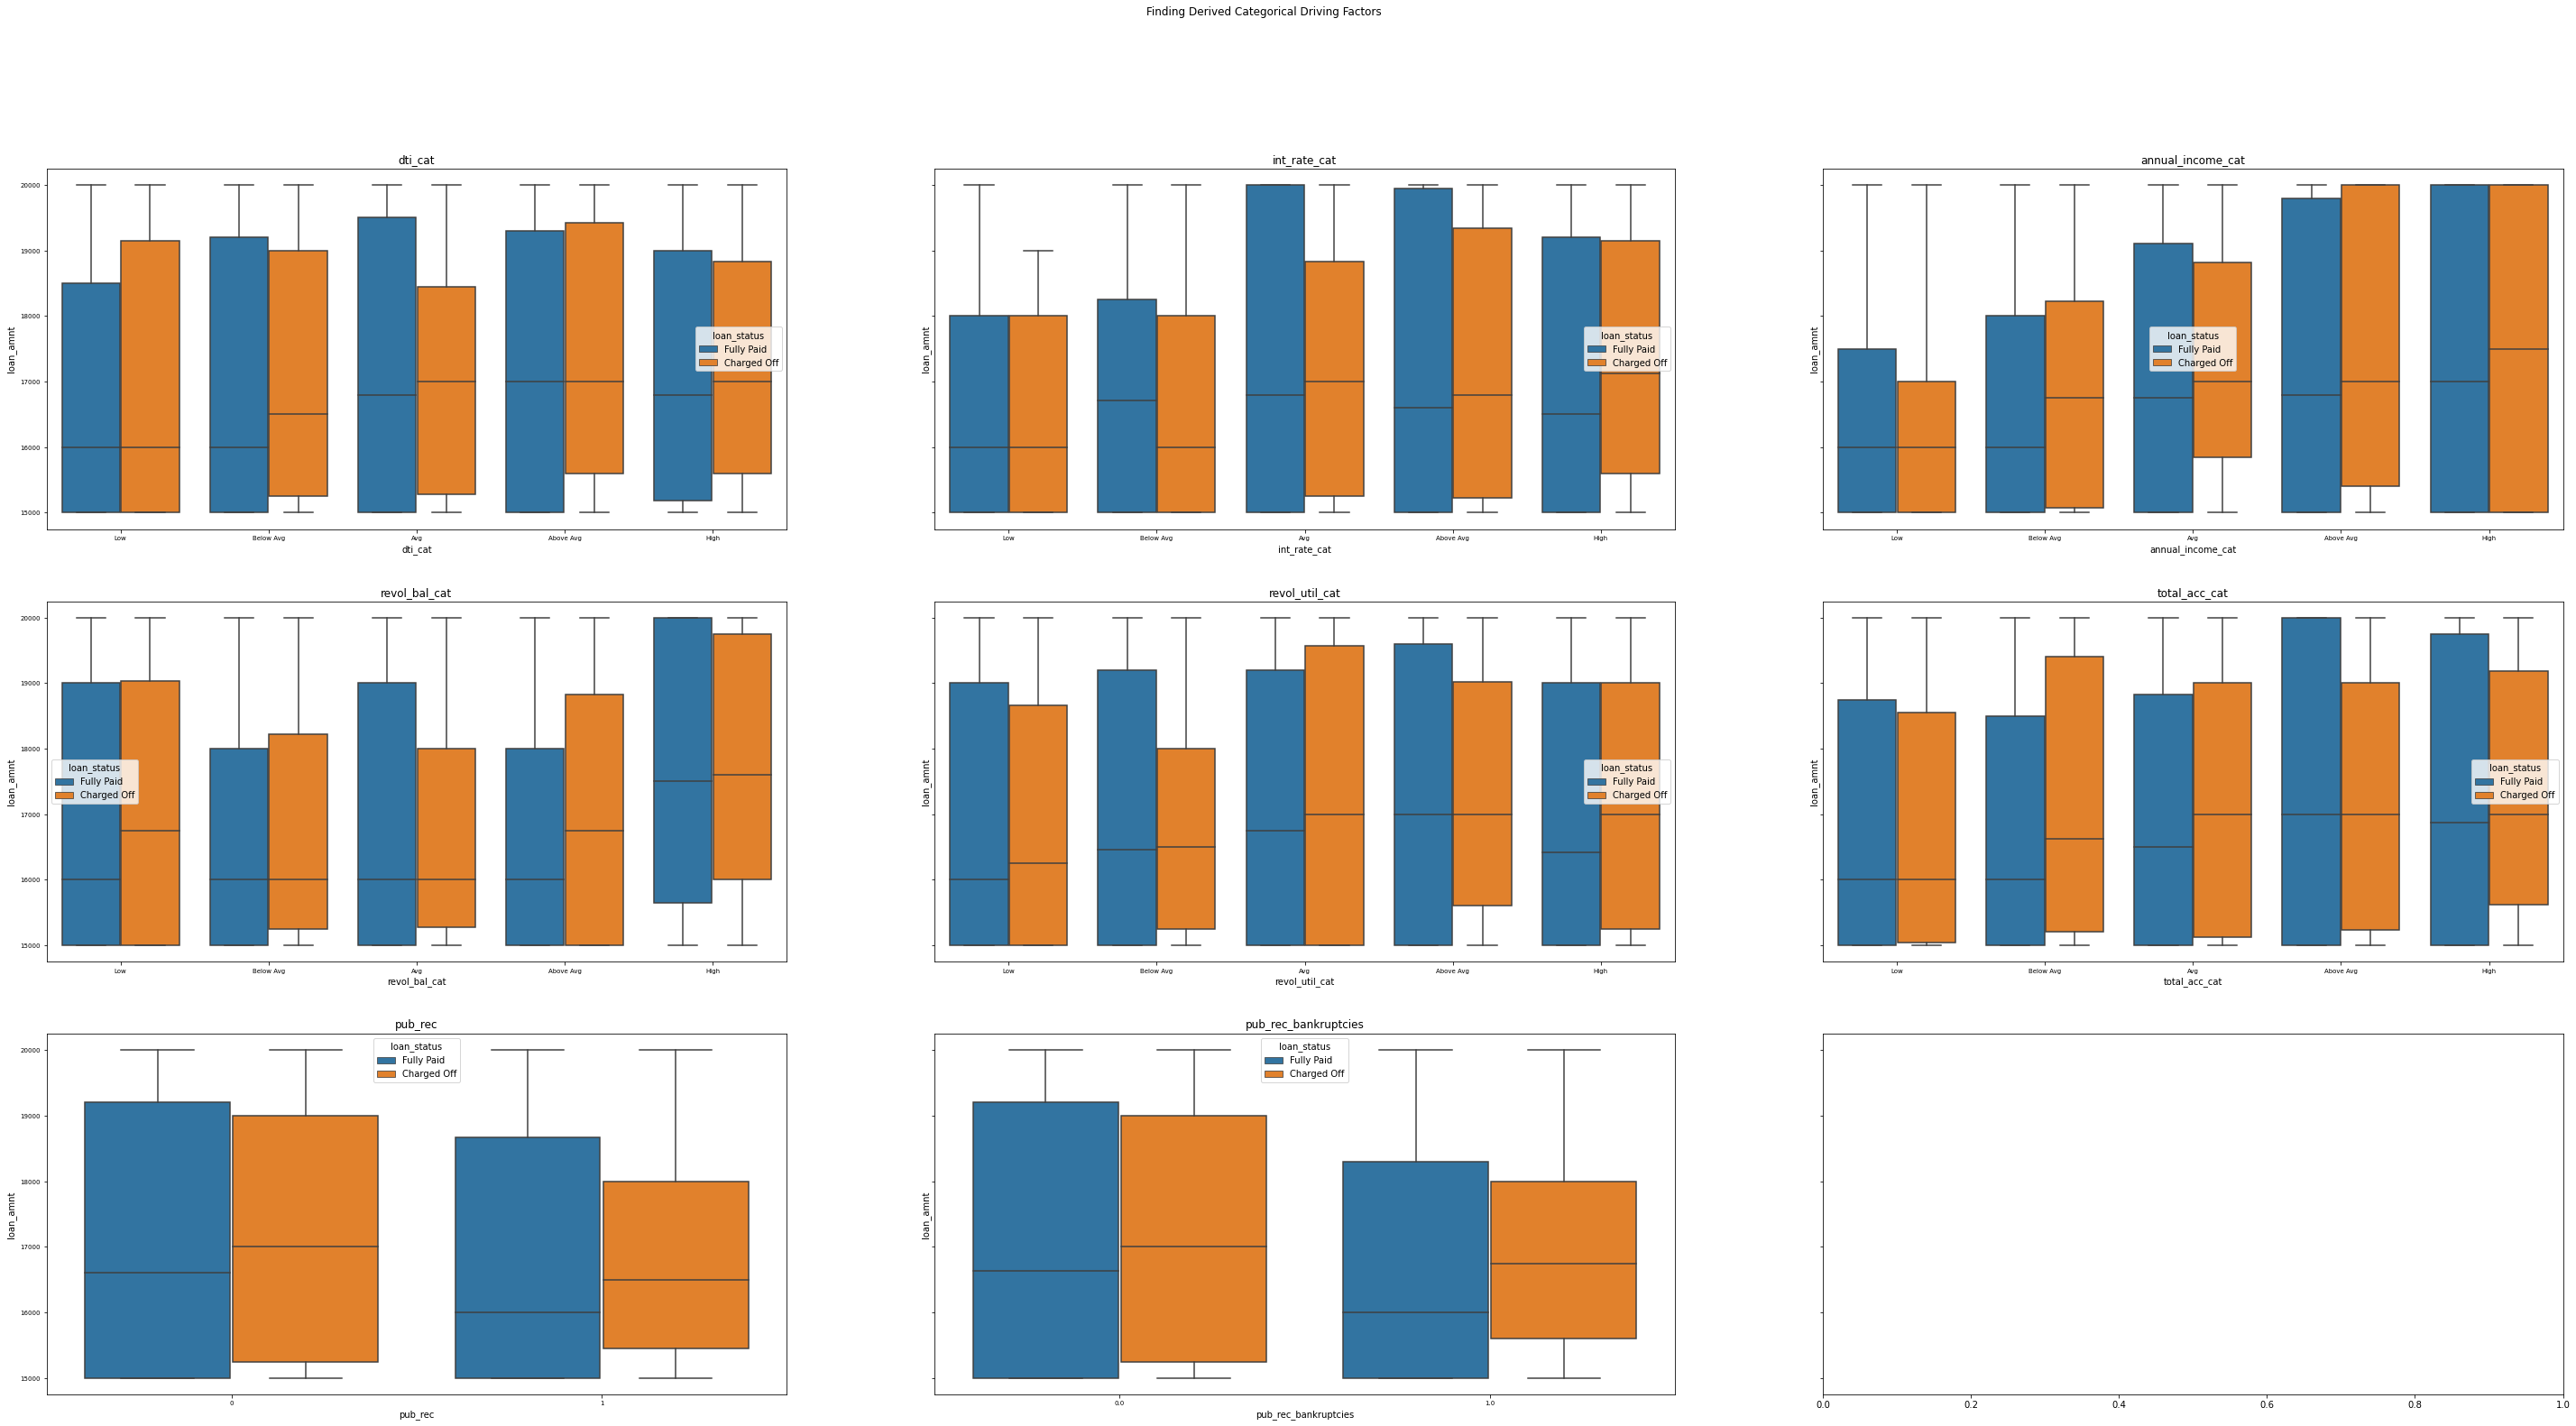

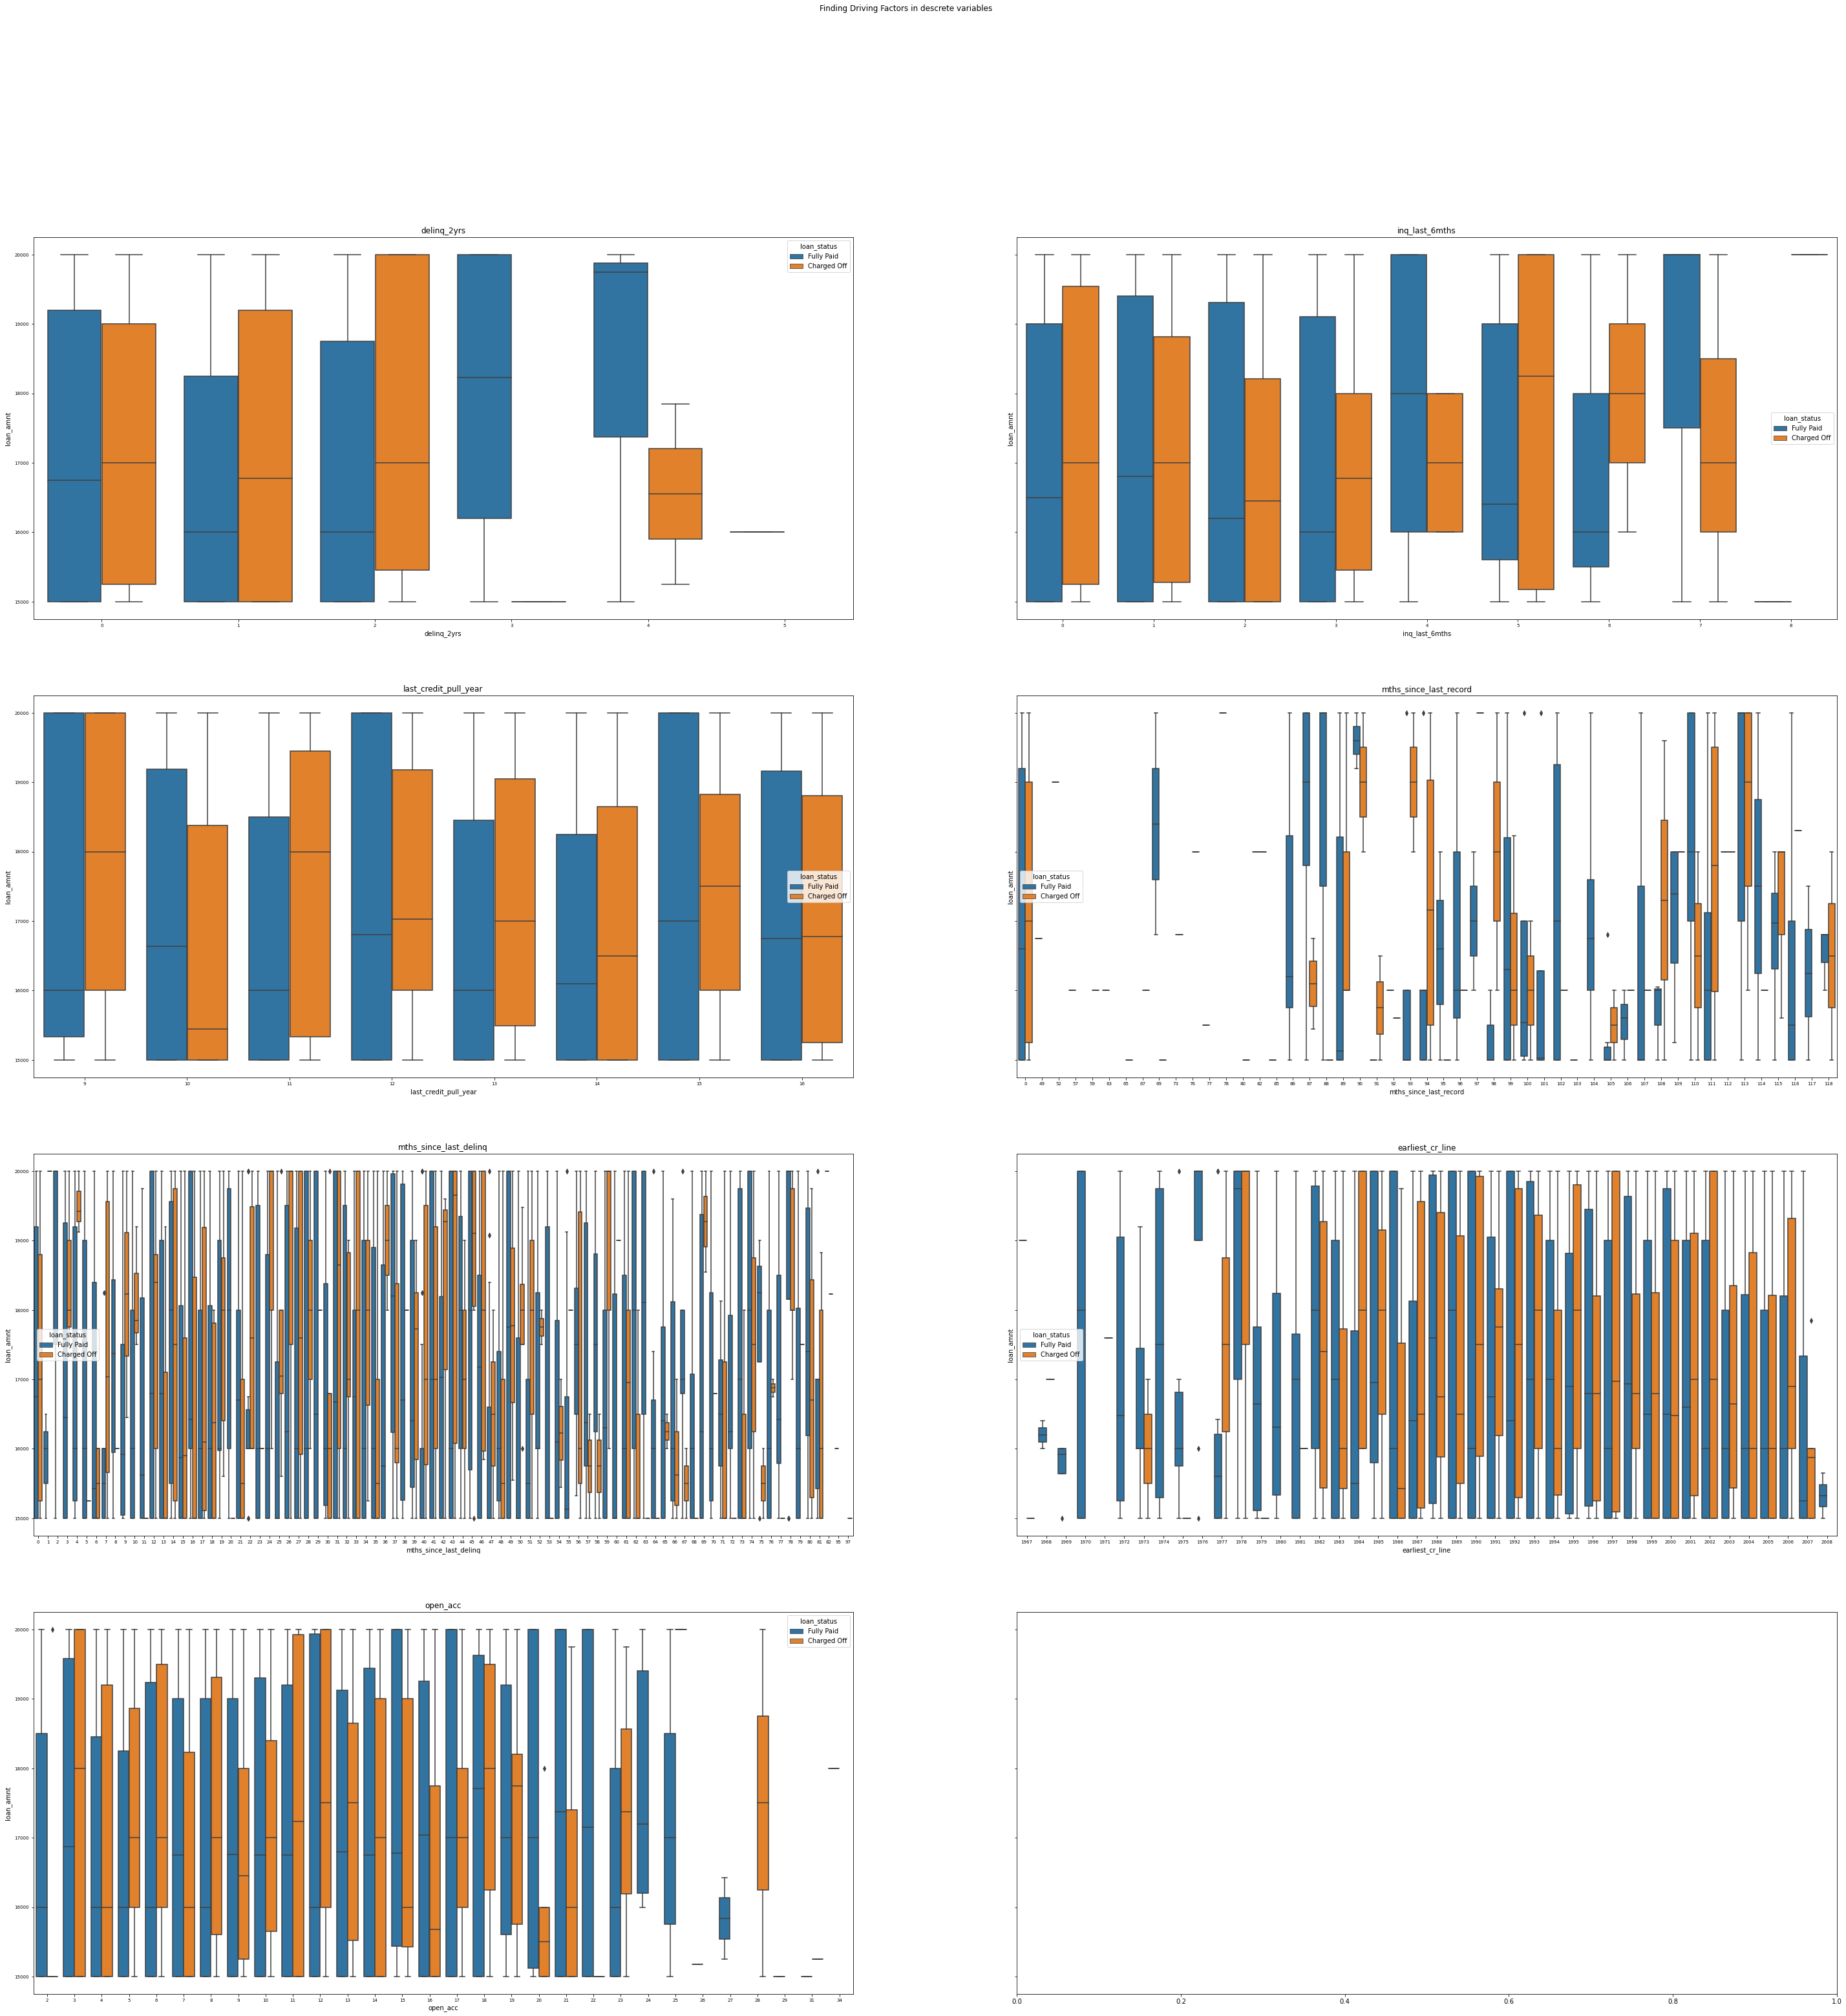

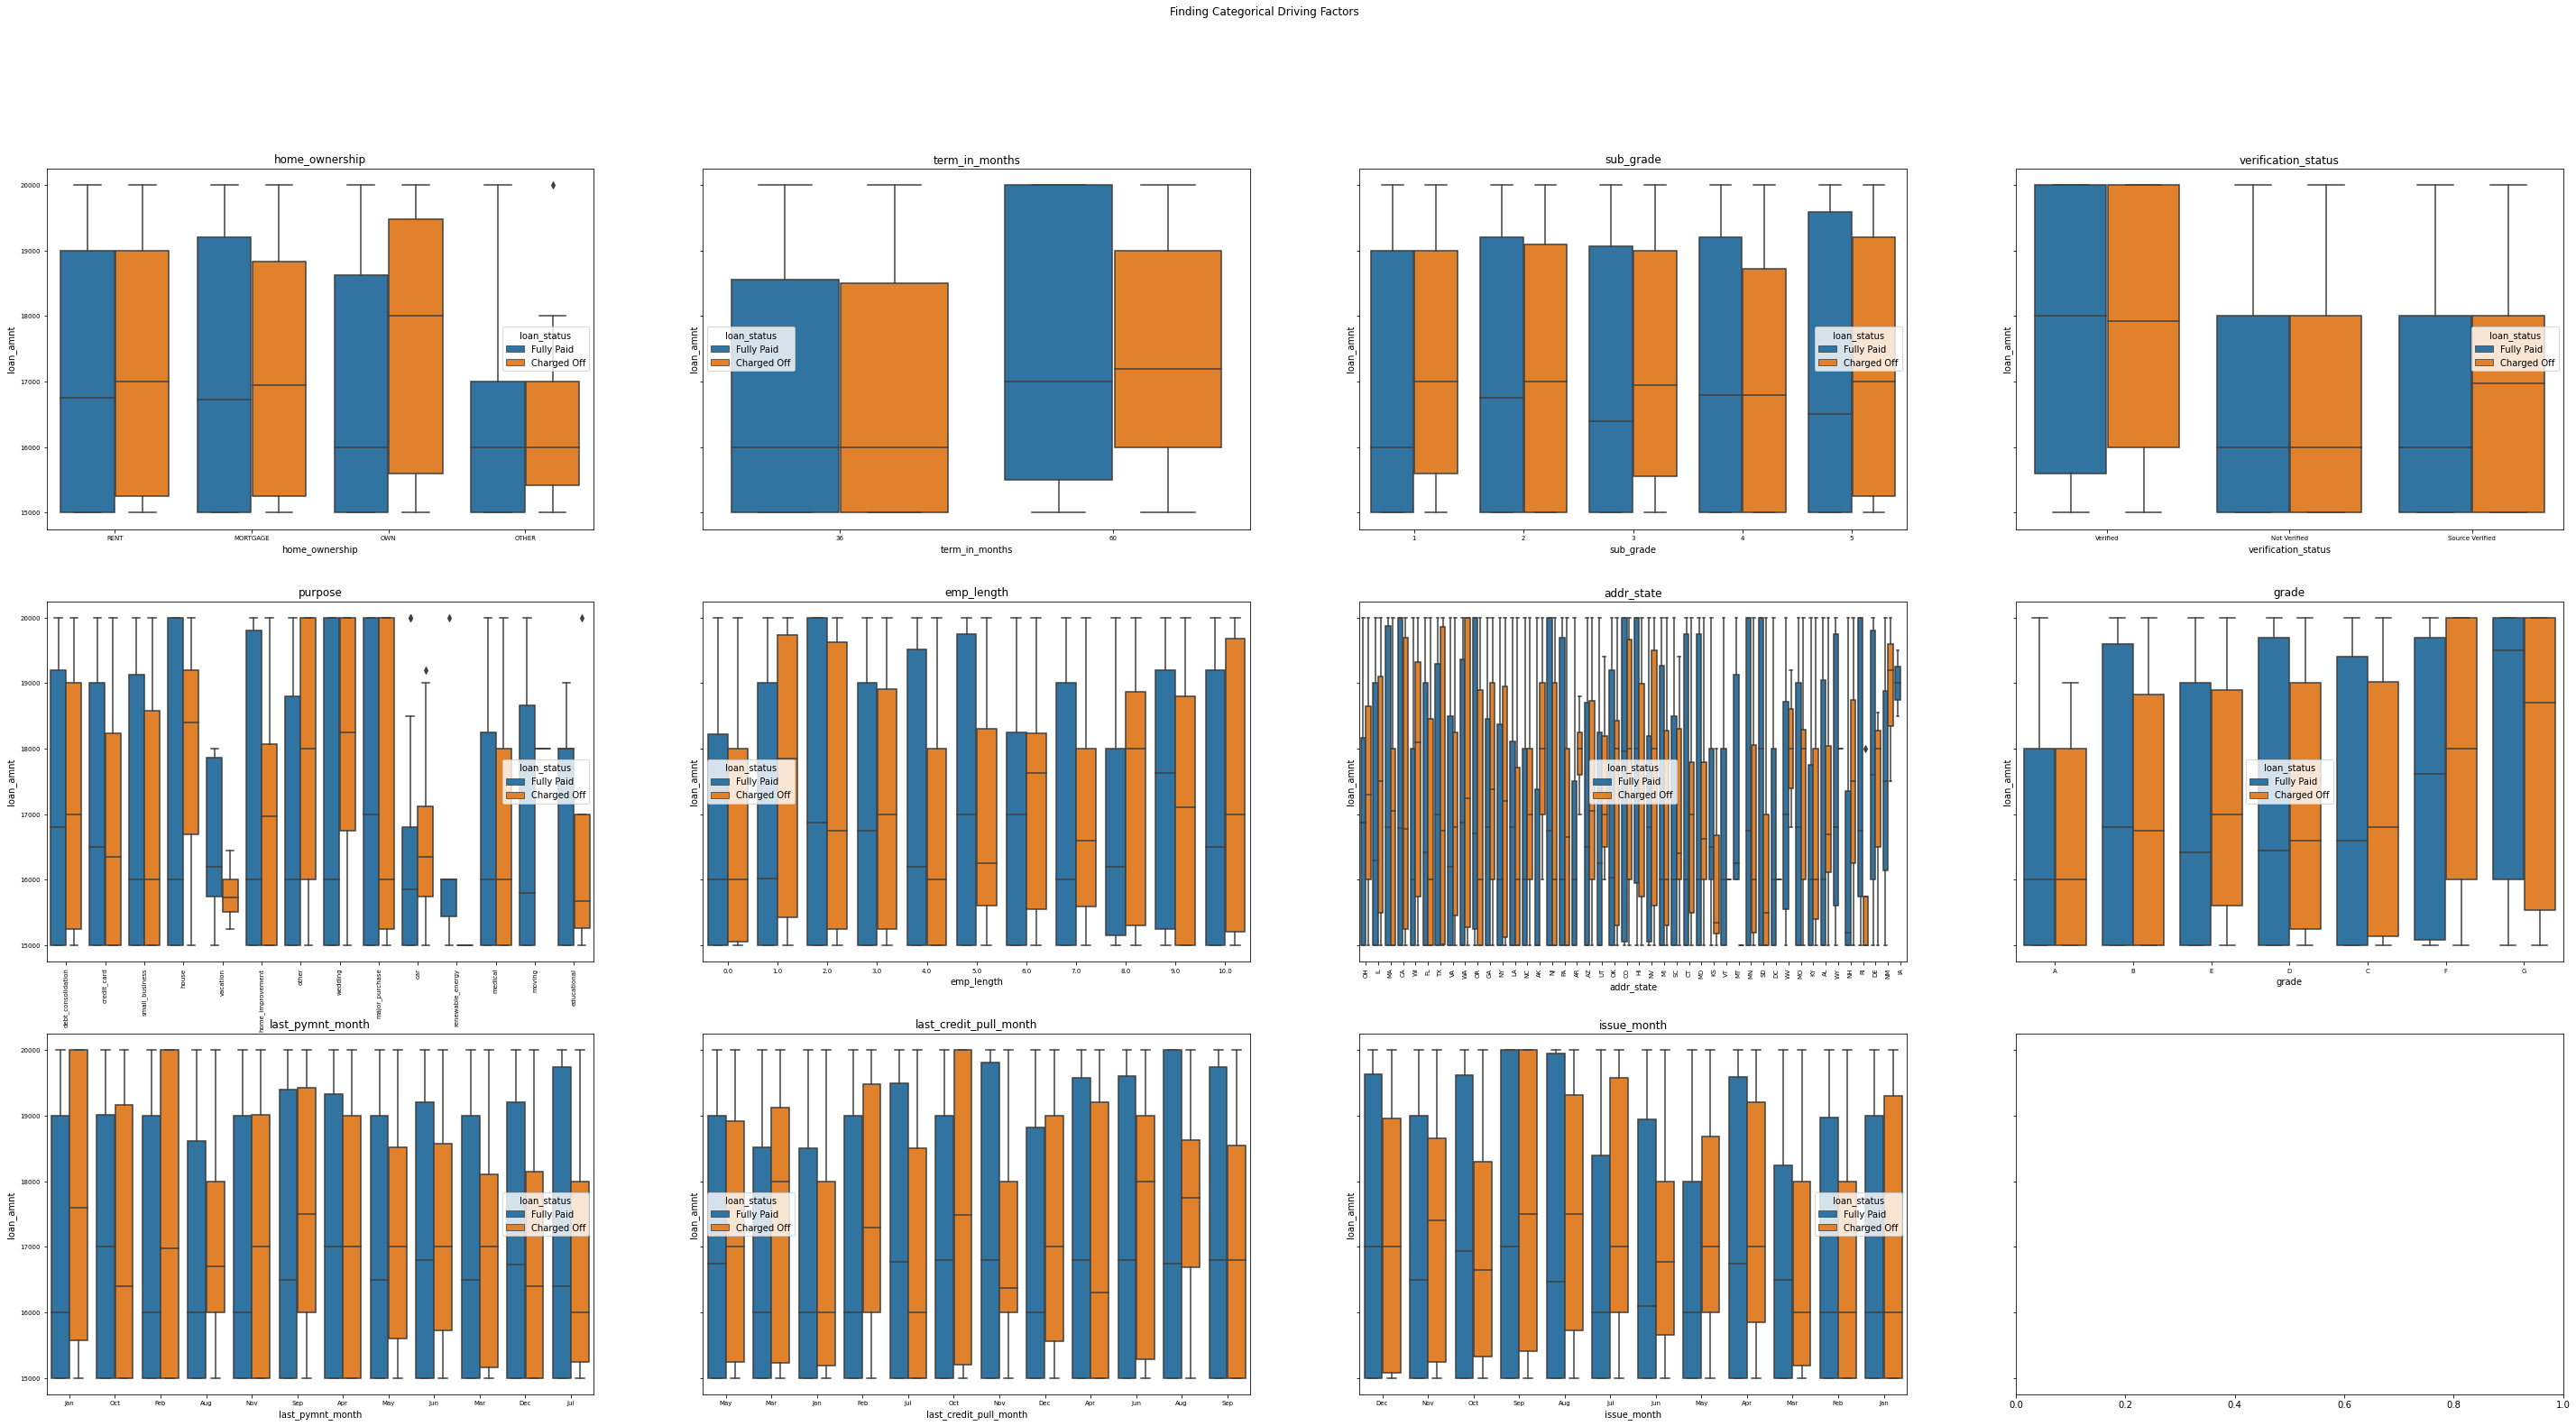

In [747]:
loan_analysis_15=loan_analysis[(loan_analysis.loan_amnt>=15000)&(loan_analysis.loan_amnt<=20000)]
print("Choose DF")
plotToChooseDrivingFactorDerivedCategorical(loan_analysis_15)
plotToChooseDrivingFactorDescrete(loan_analysis_15)
plotToChooseDrivingFactorCategorical(loan_analysis_15)

loan_analysis_15=loan_analysis_15[(loan_analysis_15.loan_amnt>=15000)&(loan_analysis_15.loan_amnt<=20000)]
loan_analysis_15=loan_analysis_15[loan_analysis_15.inq_last_6mths>=5]
loan_analysis_15=loan_analysis_15[(loan_analysis_15.revol_bal_cat=='High')]
loan_analysis_15=loan_analysis_15[(loan_analysis_15.dti_cat.isin(['Below Avg','Low']))]
loan_analysis_15=loan_analysis_15[(loan_analysis_15.open_acc>10)]

printDiffFullyPaidAndChargedOff(loan_analysis_15)


Total fully paid loan amount in slice 0
Total charged off loan amount in slice 47200
The difference between fully paid and charged off -47200




array(['Charged Off'], dtype=object)

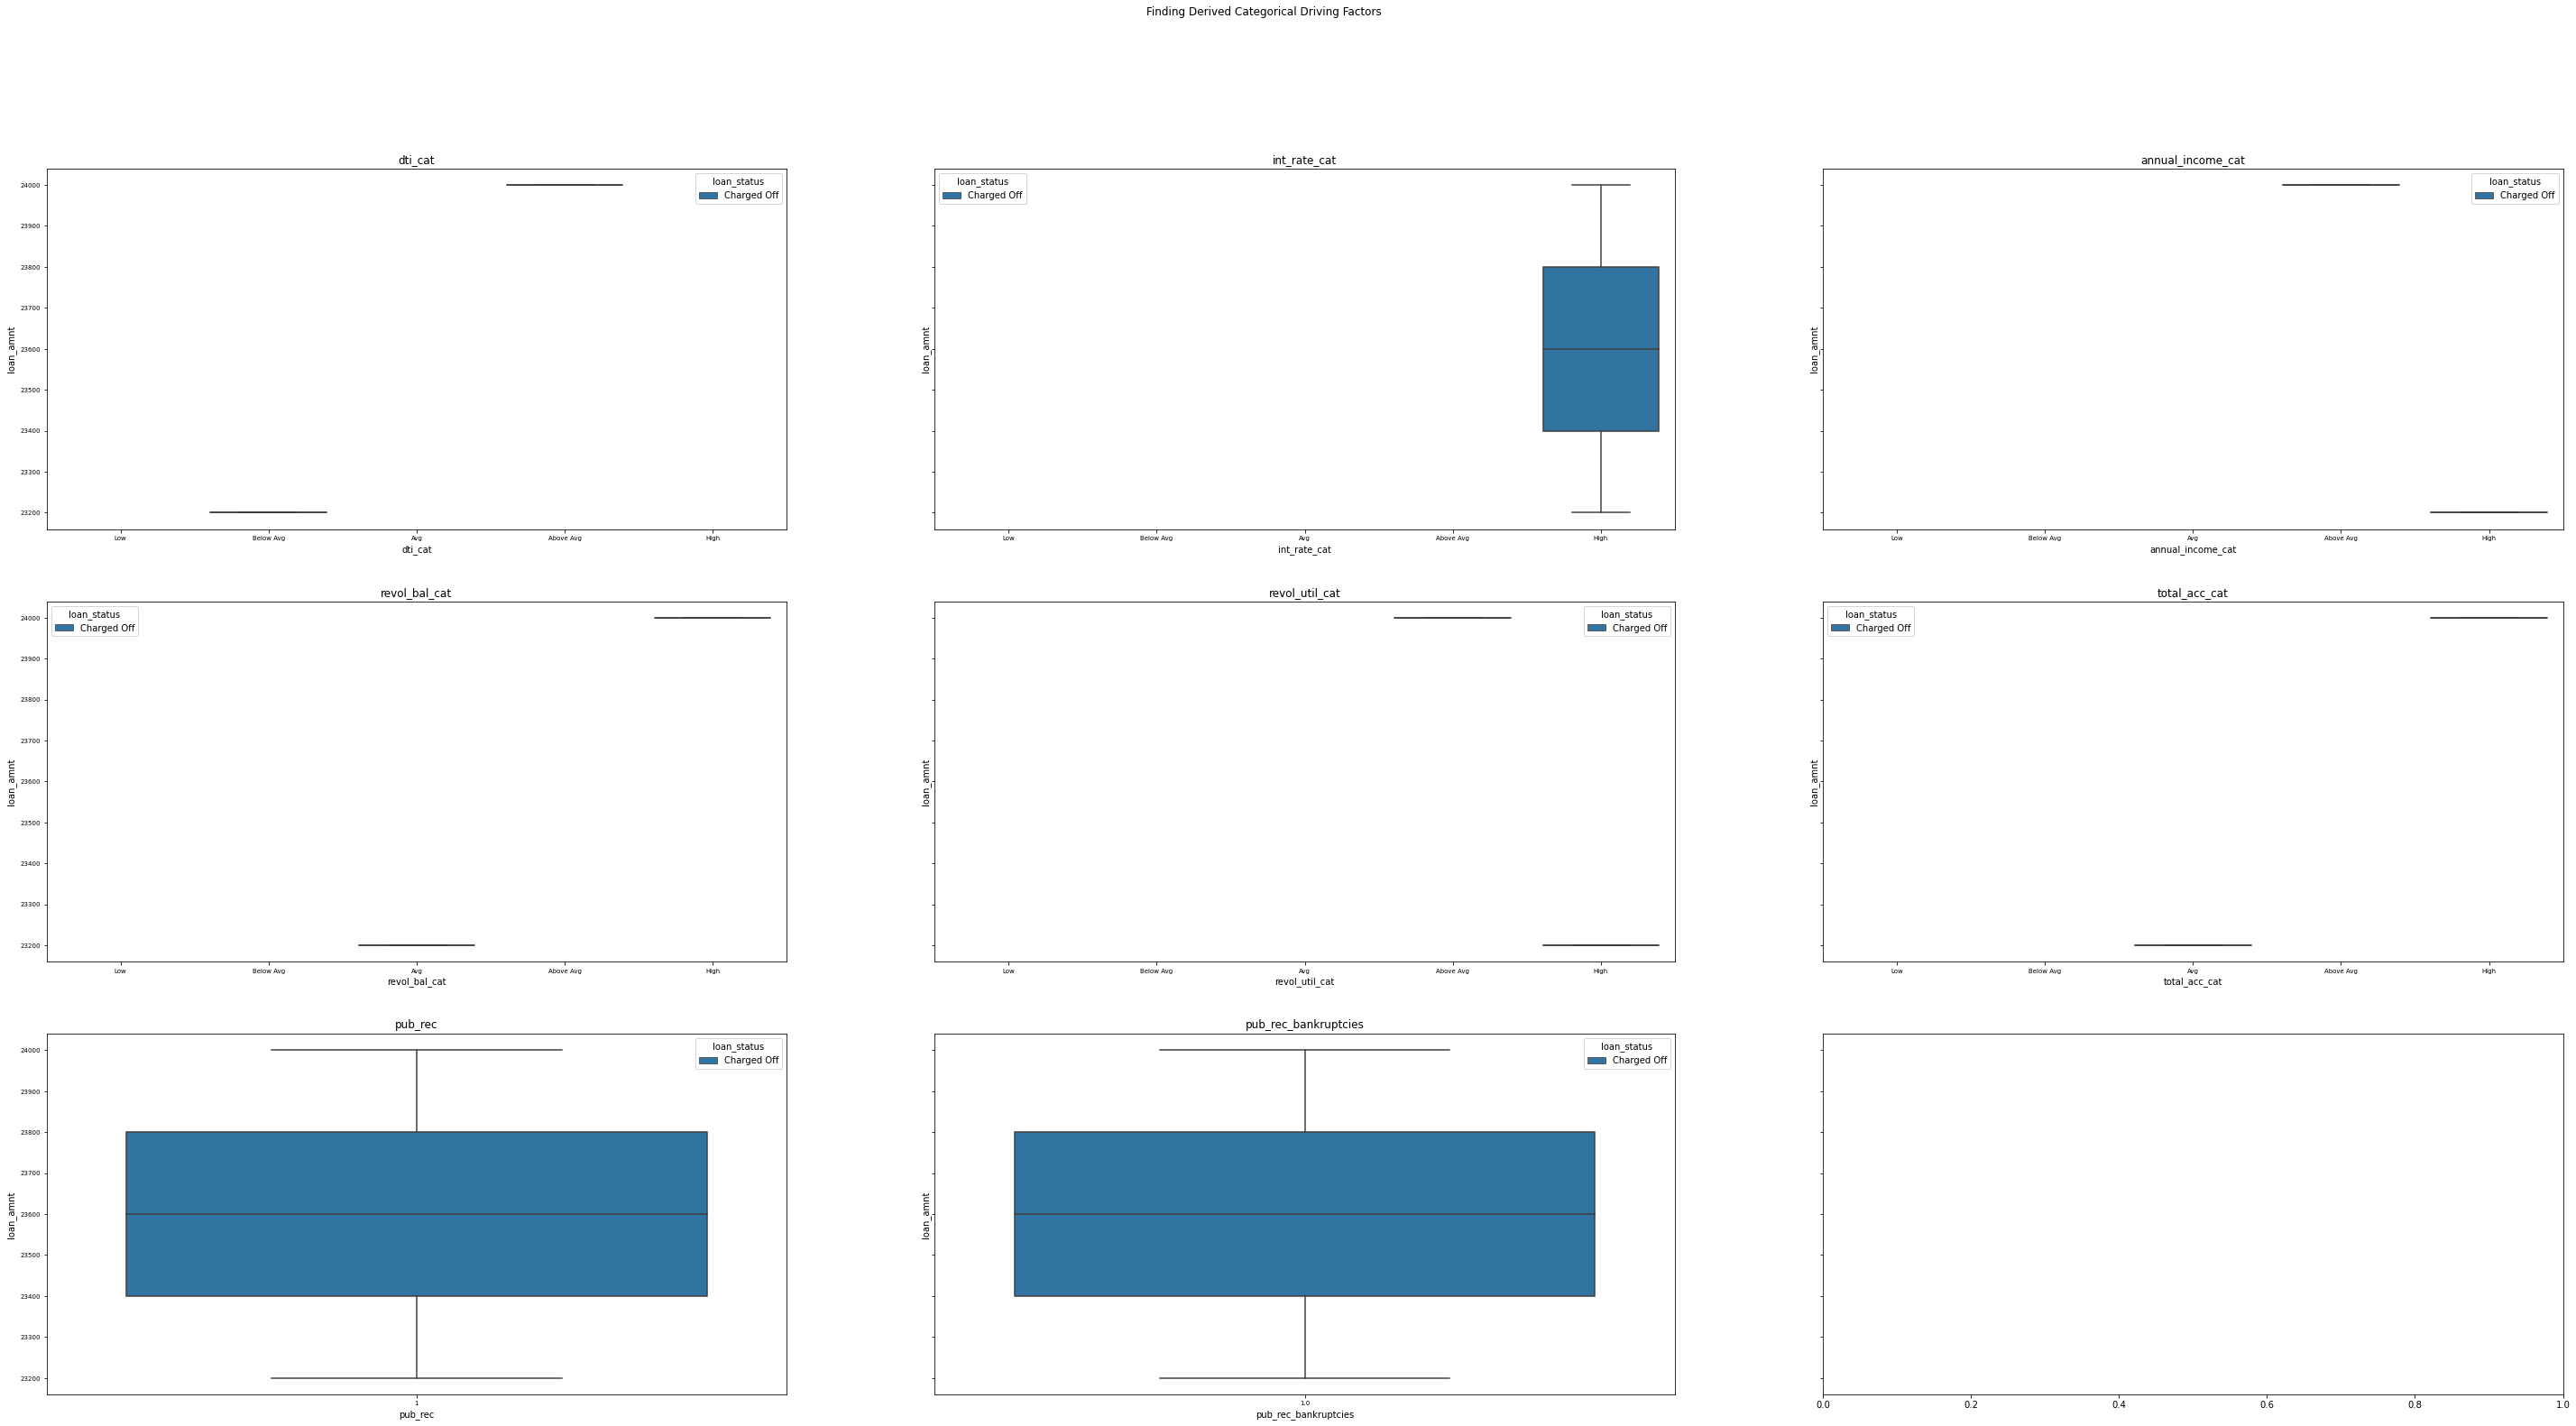

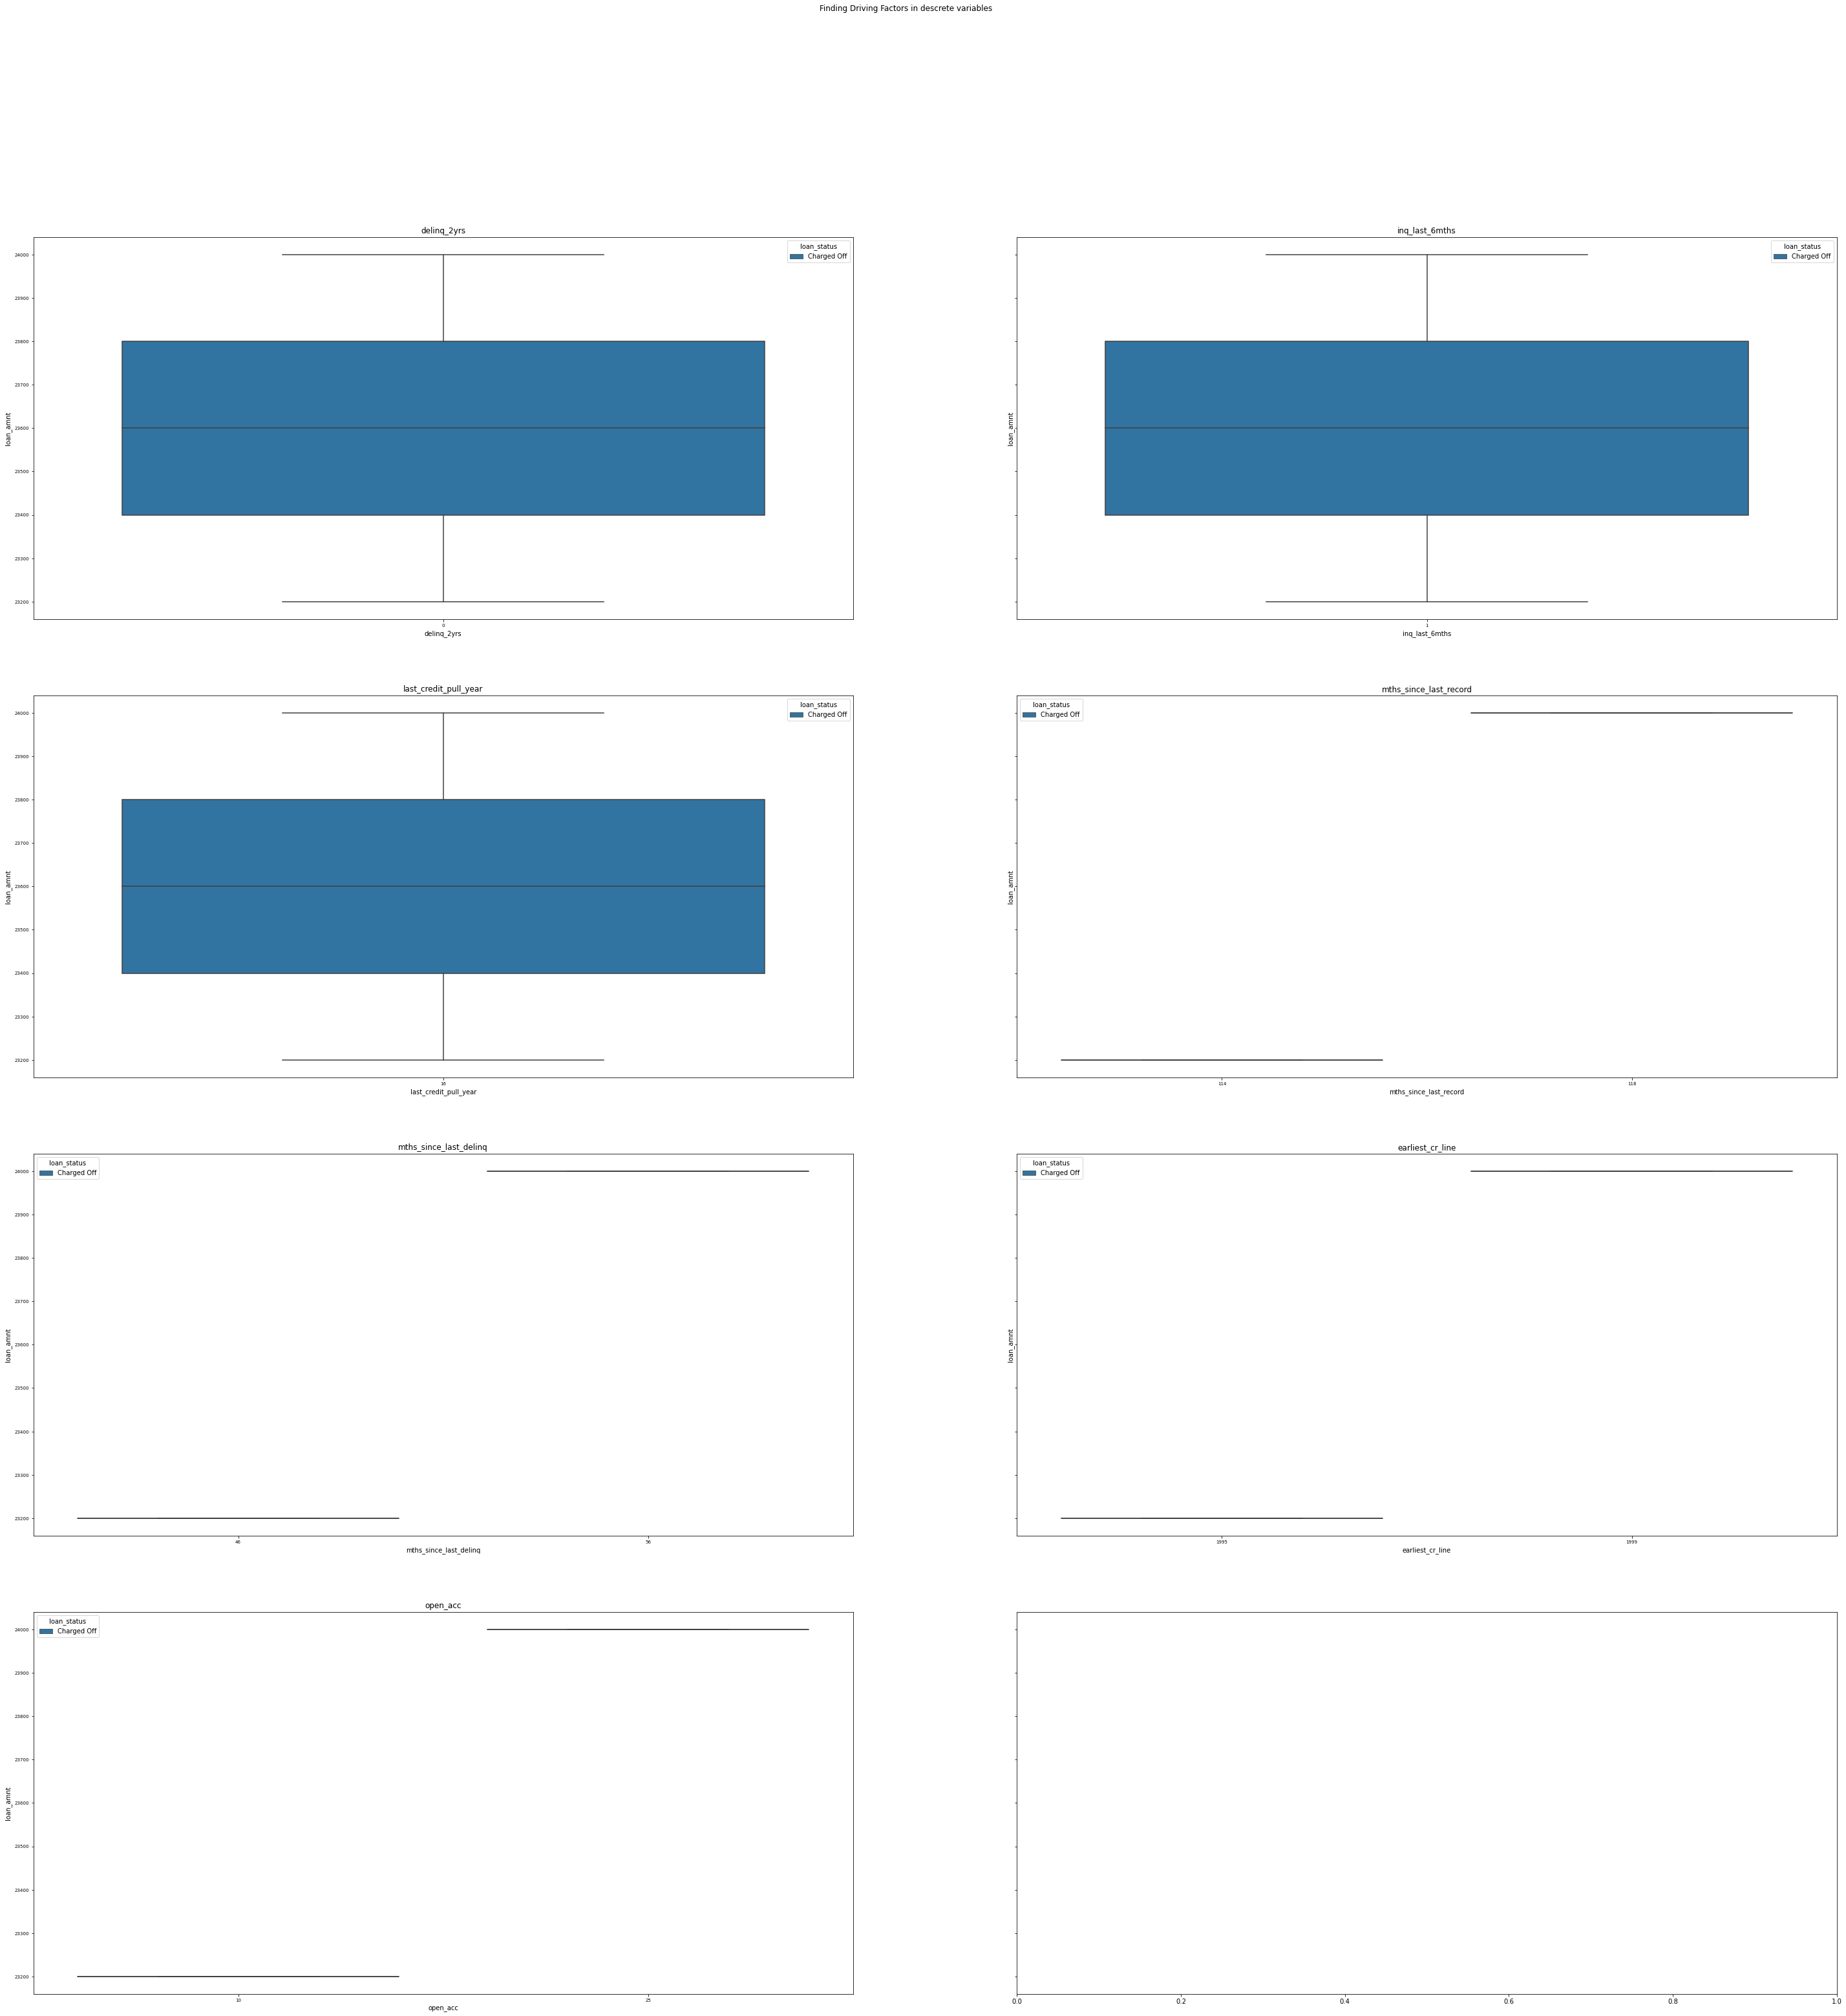

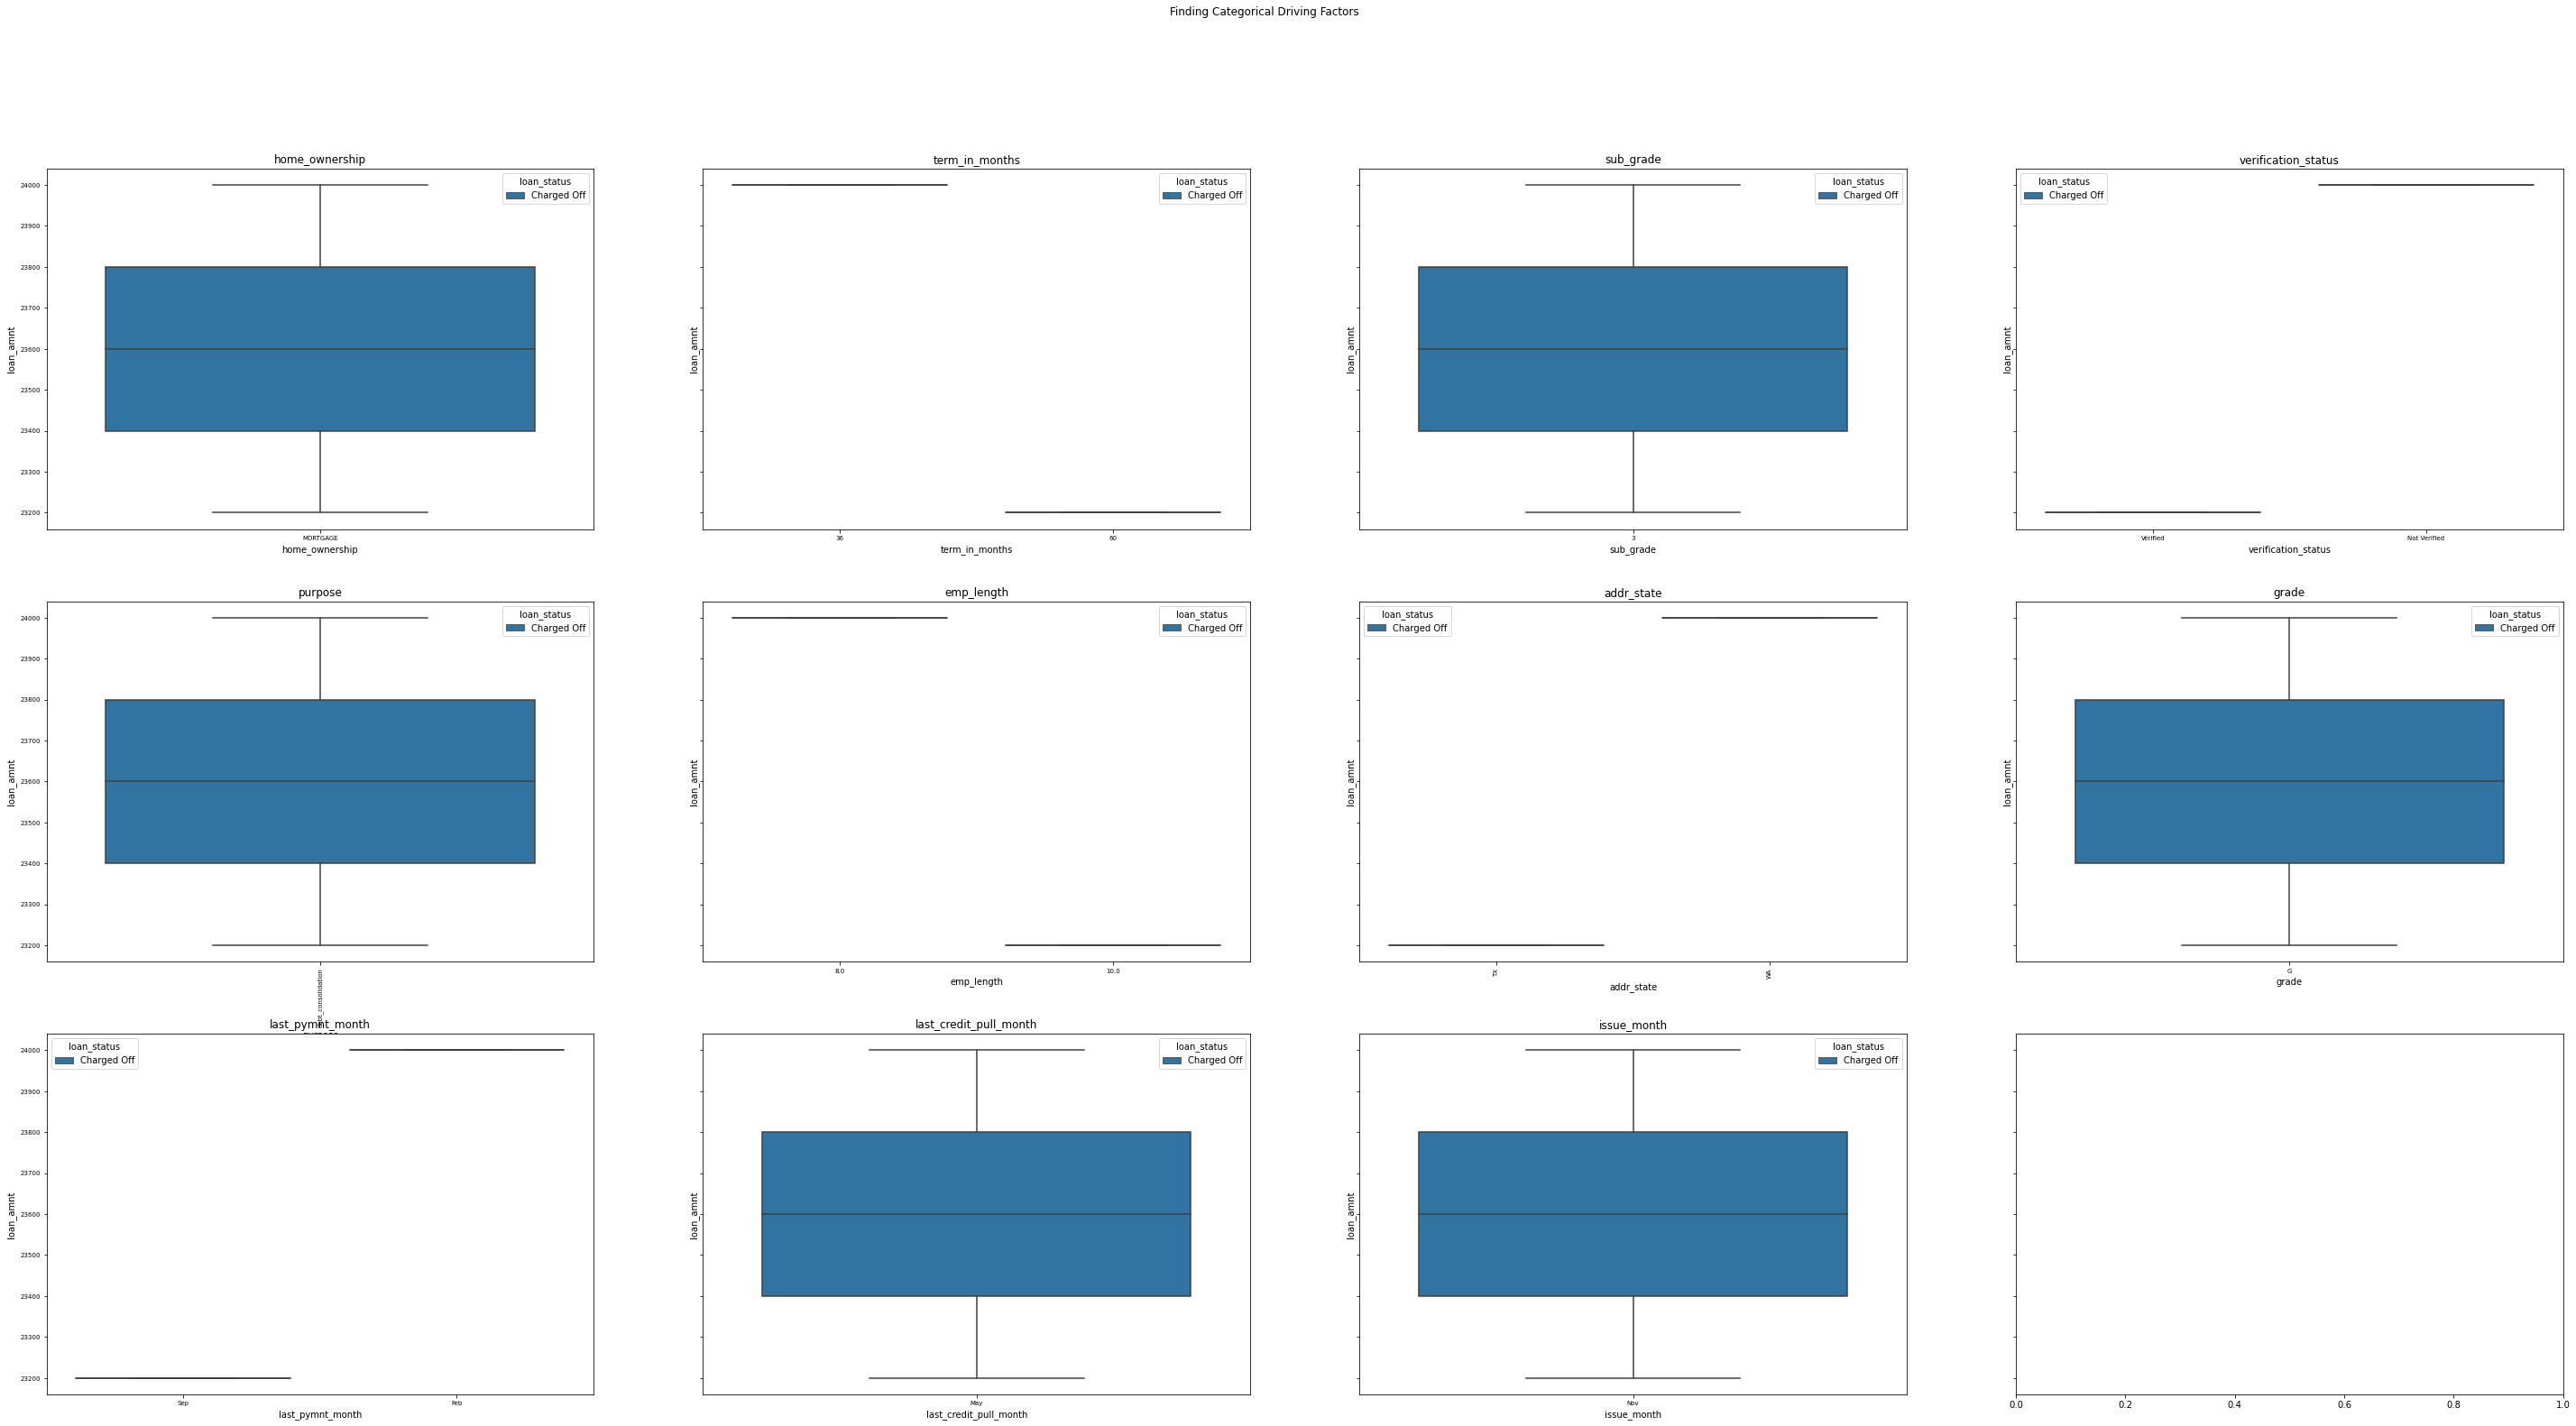

In [748]:
loan_analysis_20=loan_analysis[(loan_analysis.pub_rec_bankruptcies==1)&(loan_analysis.loan_amnt>20000)&(loan_analysis.loan_amnt<=25000)]
loan_analysis_20=loan_analysis_20[~loan_analysis_20.dti_cat.isin(['Low','Avg'])]
loan_analysis_20=loan_analysis_20[loan_analysis_20.int_rate_cat=='High']
loan_analysis_20=loan_analysis_20[loan_analysis_20.annual_income_cat.isin(['Above Avg','High'])]
loan_analysis_20=loan_analysis_20[loan_analysis_20.grade.isin(['G'])]
printDiffFullyPaidAndChargedOff(loan_analysis_20)
plotToChooseDrivingFactorDerivedCategorical(loan_analysis_20)
plotToChooseDrivingFactorDescrete(loan_analysis_20)
plotToChooseDrivingFactorCategorical(loan_analysis_20)

loan_analysis_20.loan_status.unique()


Total fully paid loan amount in slice 0
Total charged off loan amount in slice 49000
The difference between fully paid and charged off -49000




array(['Charged Off'], dtype=object)

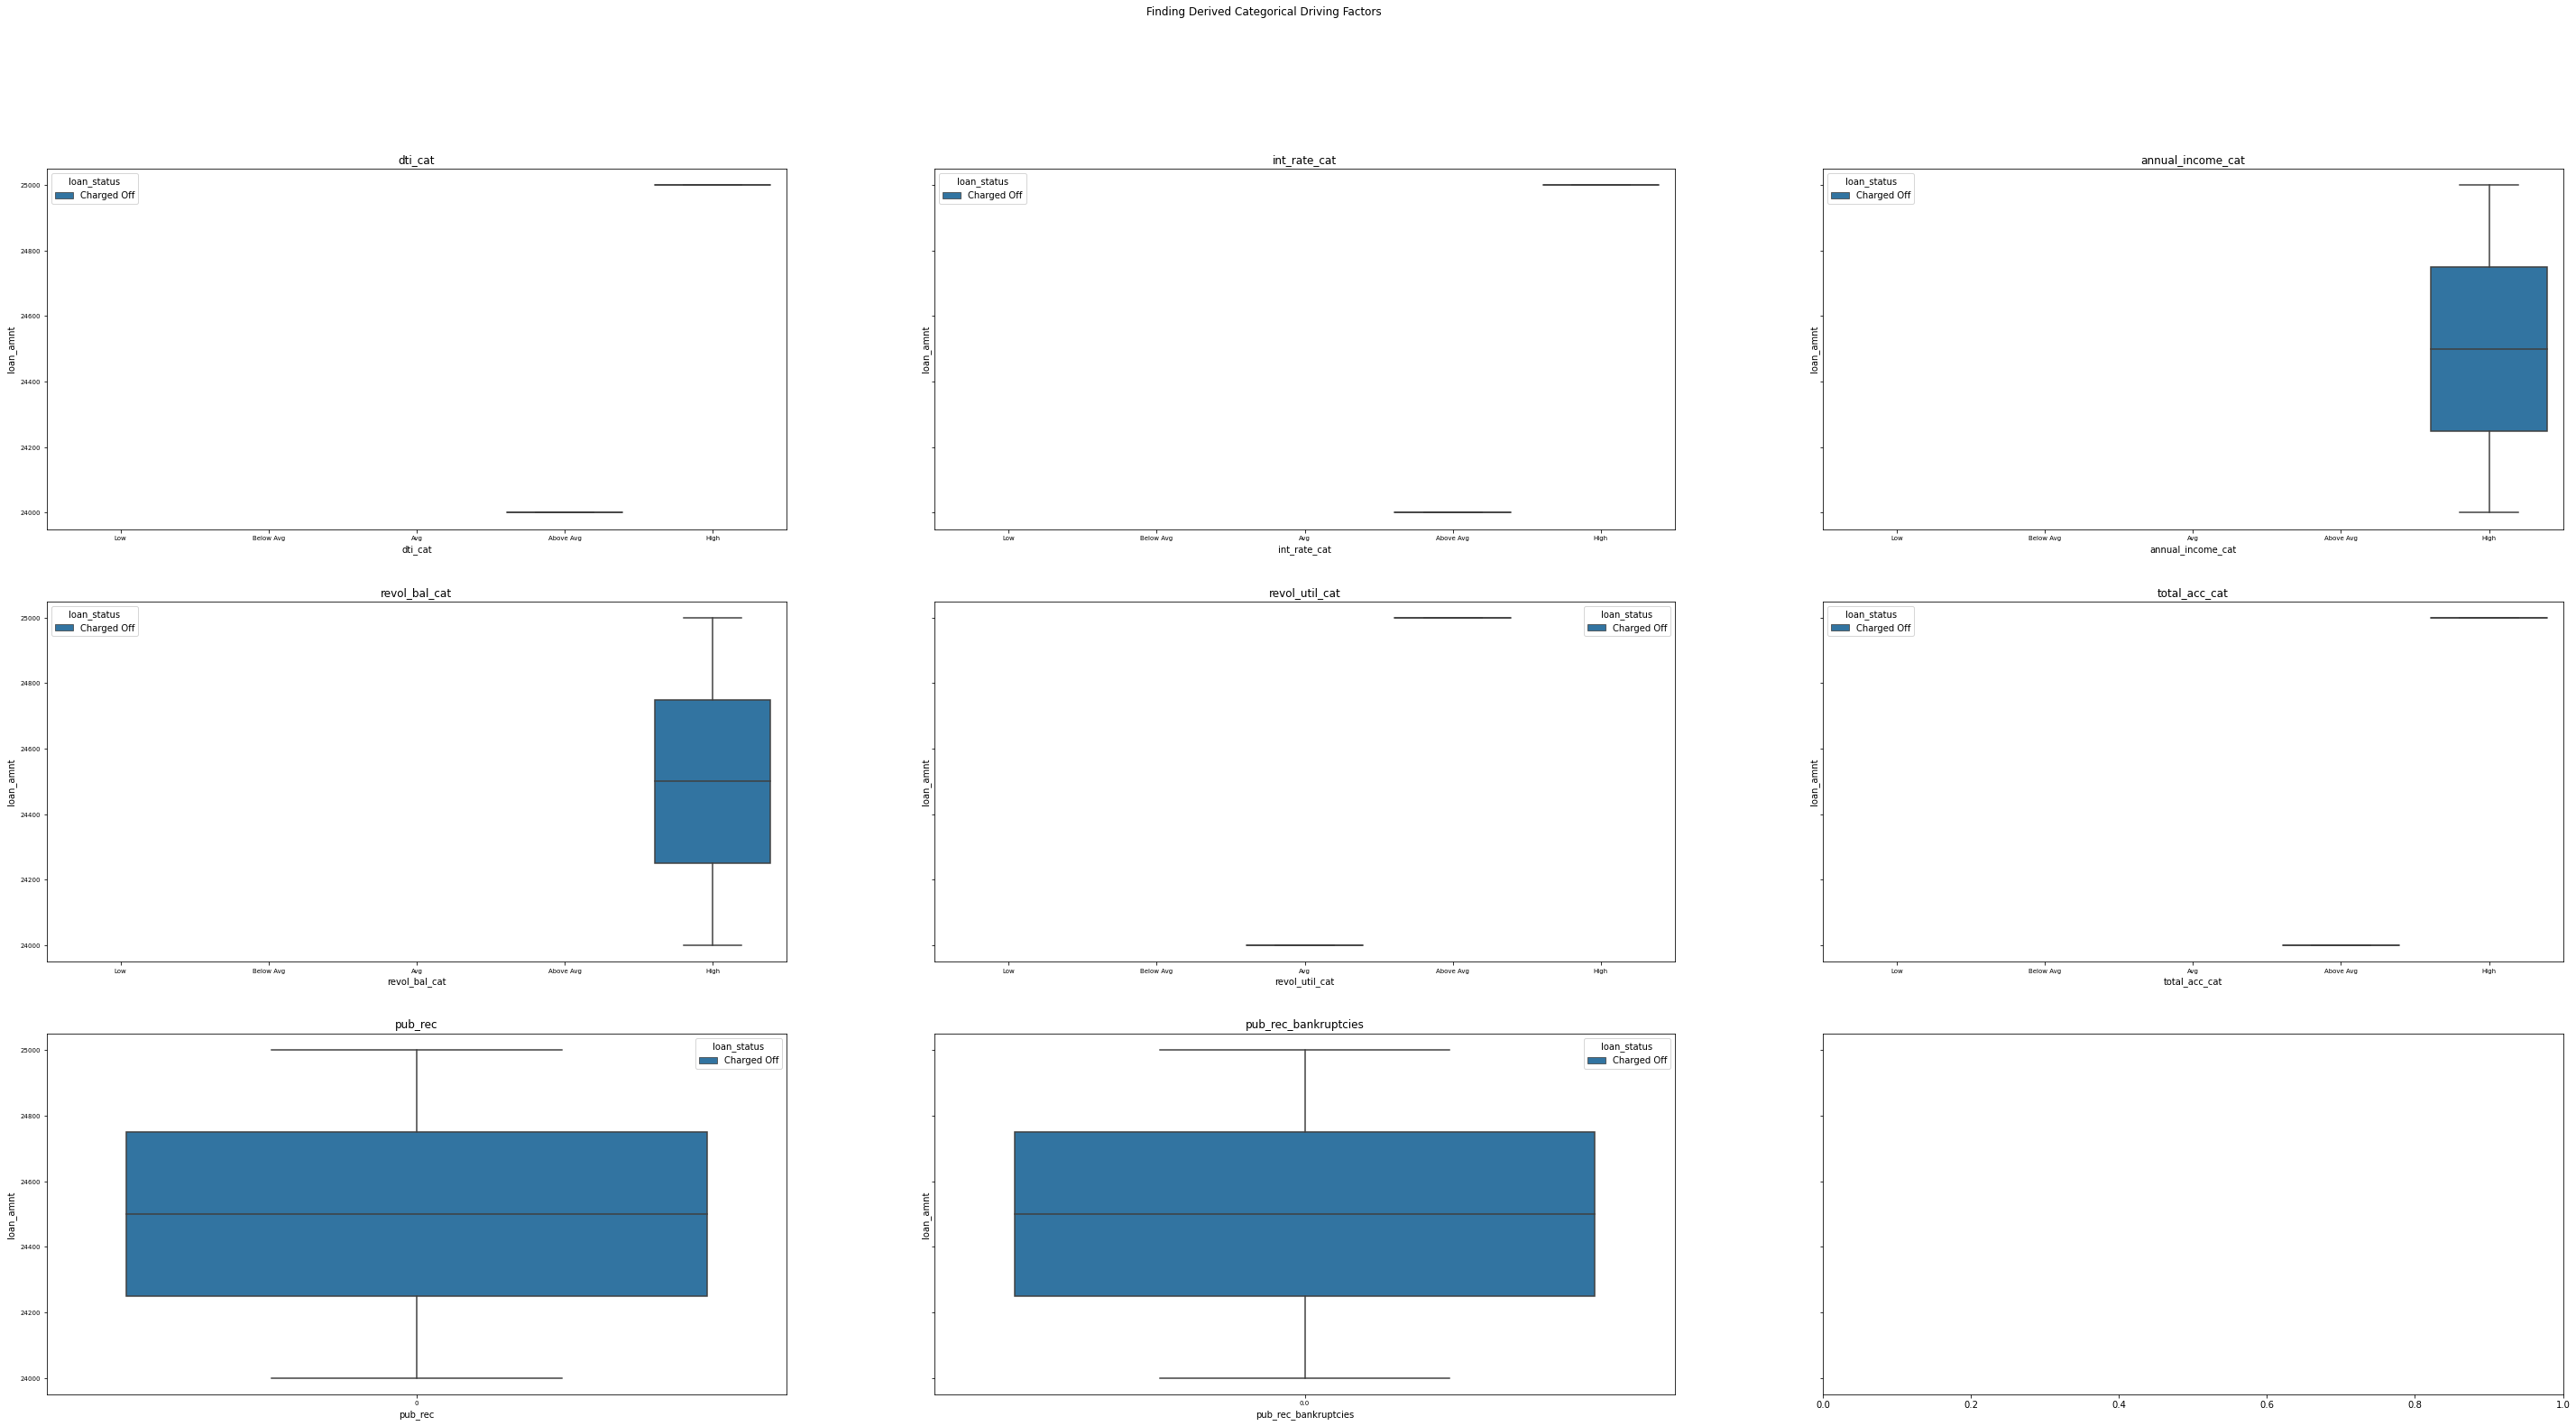

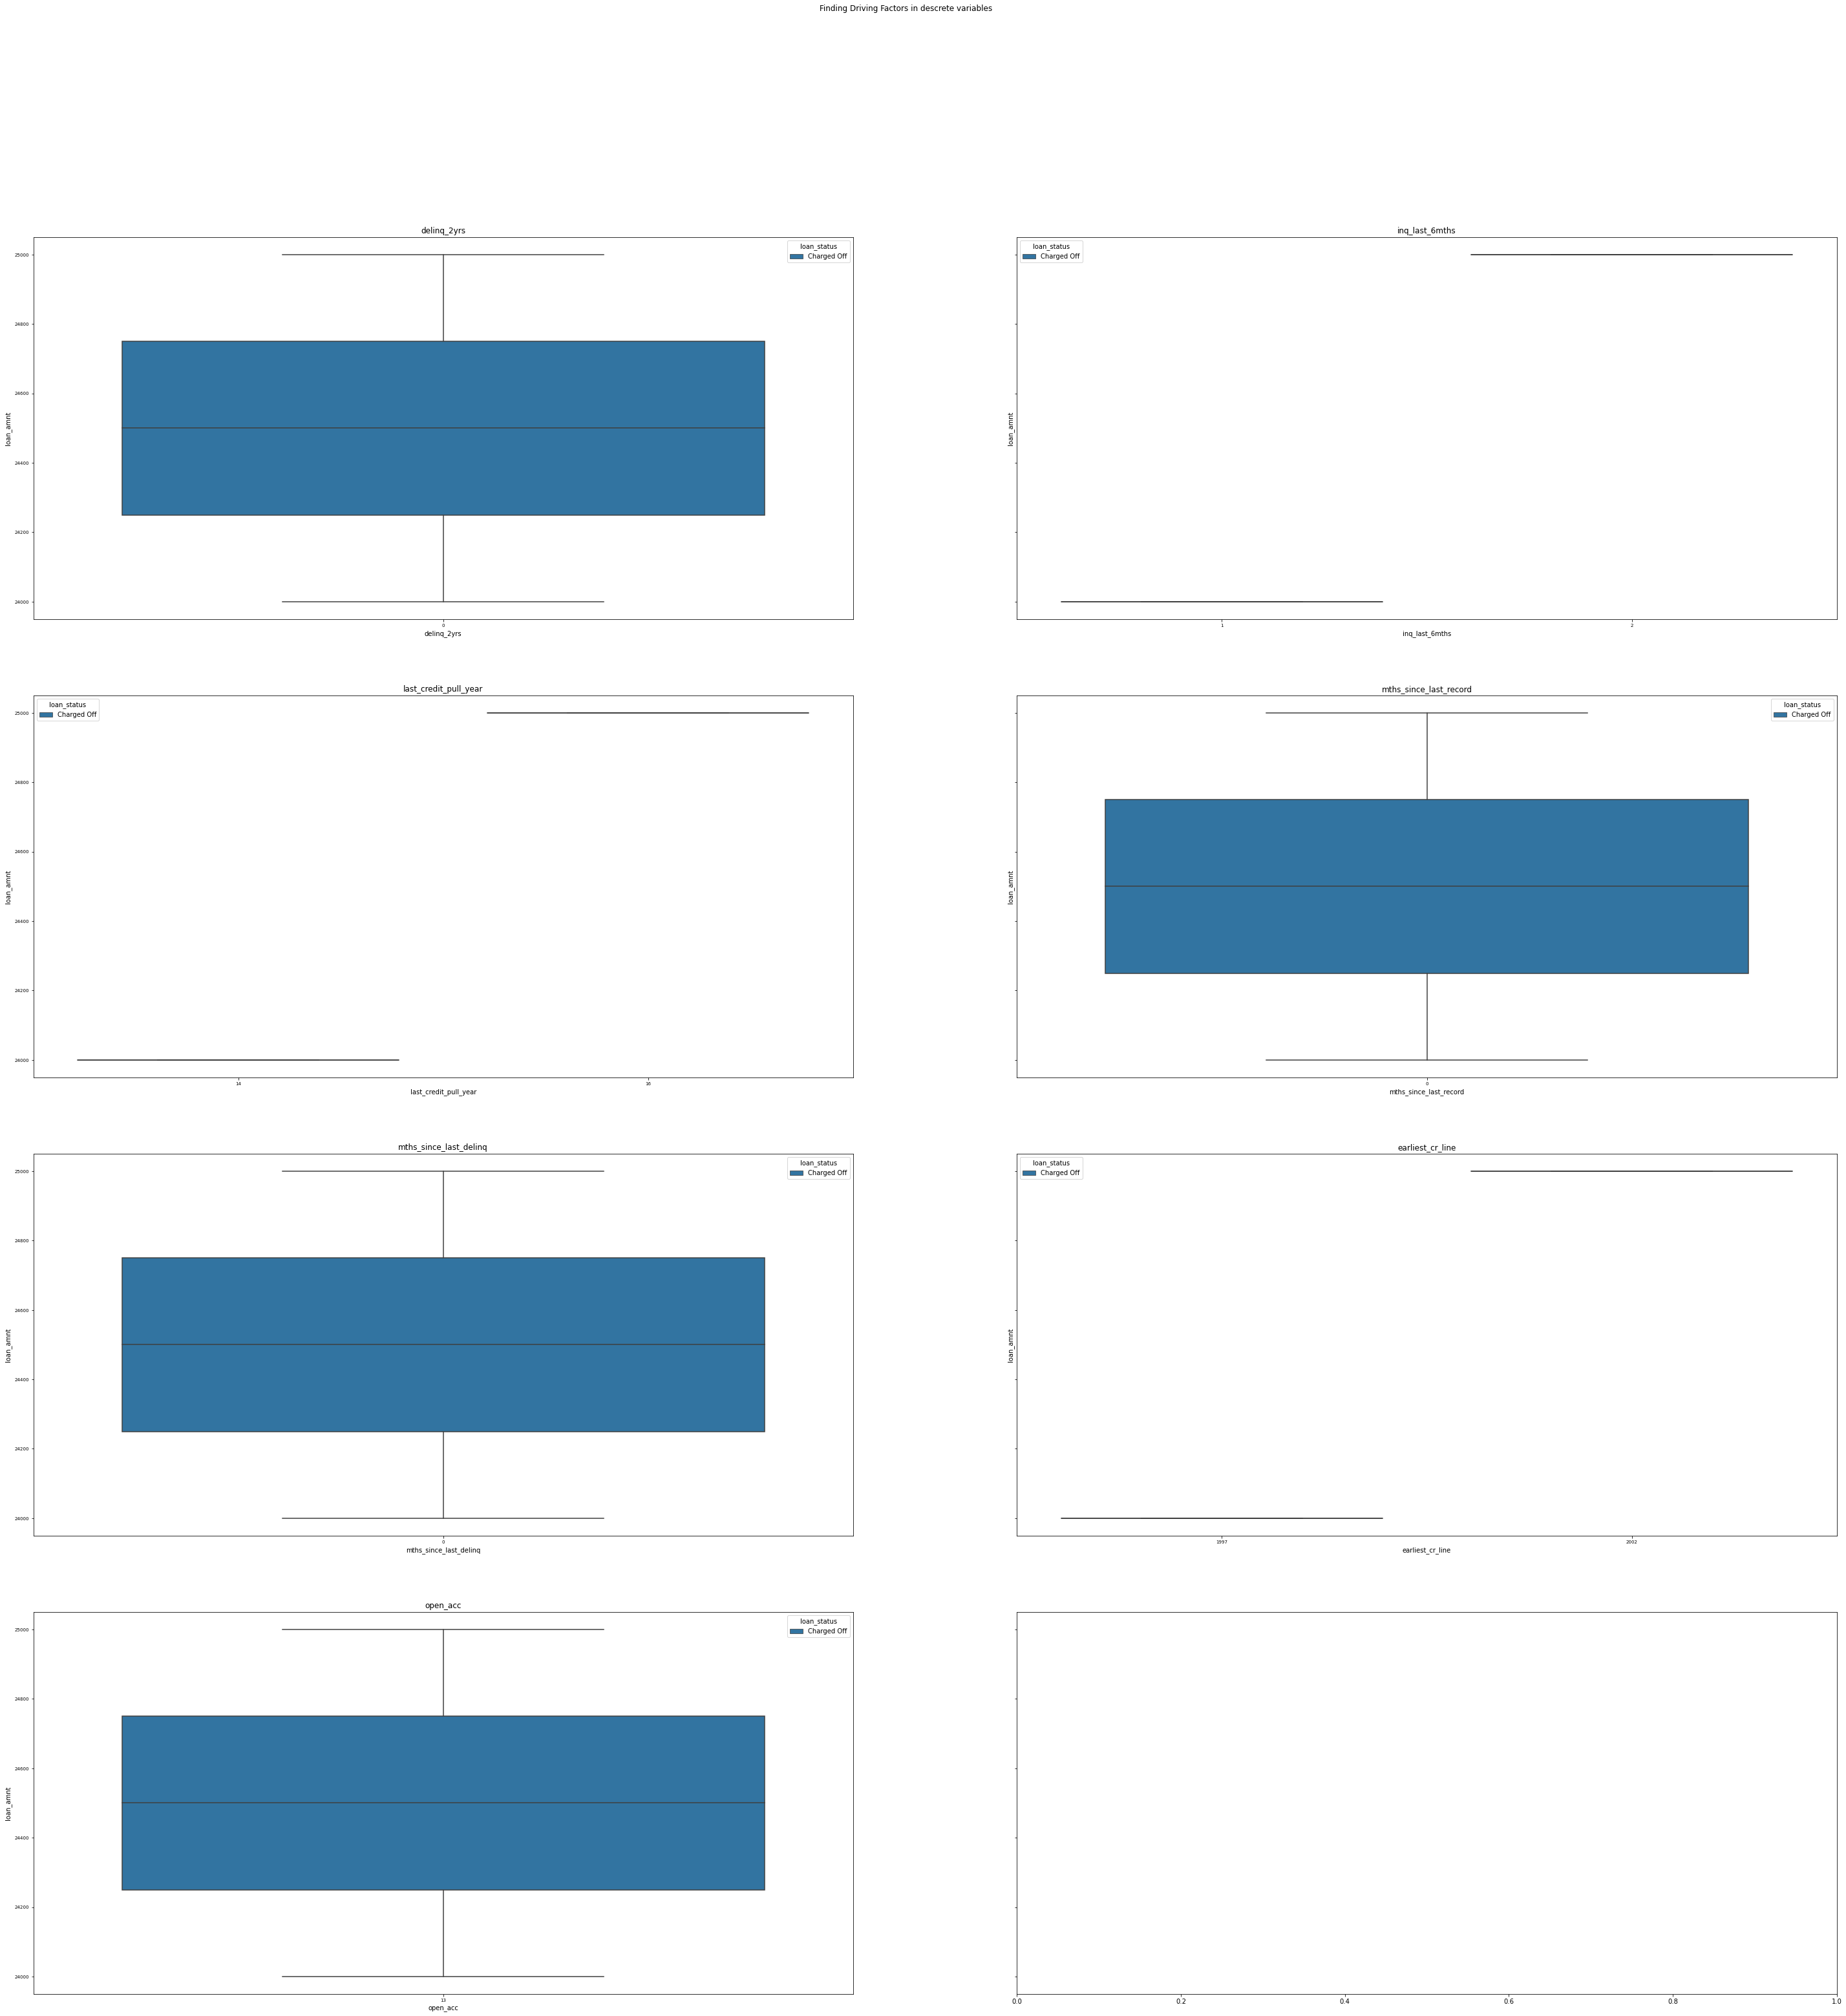

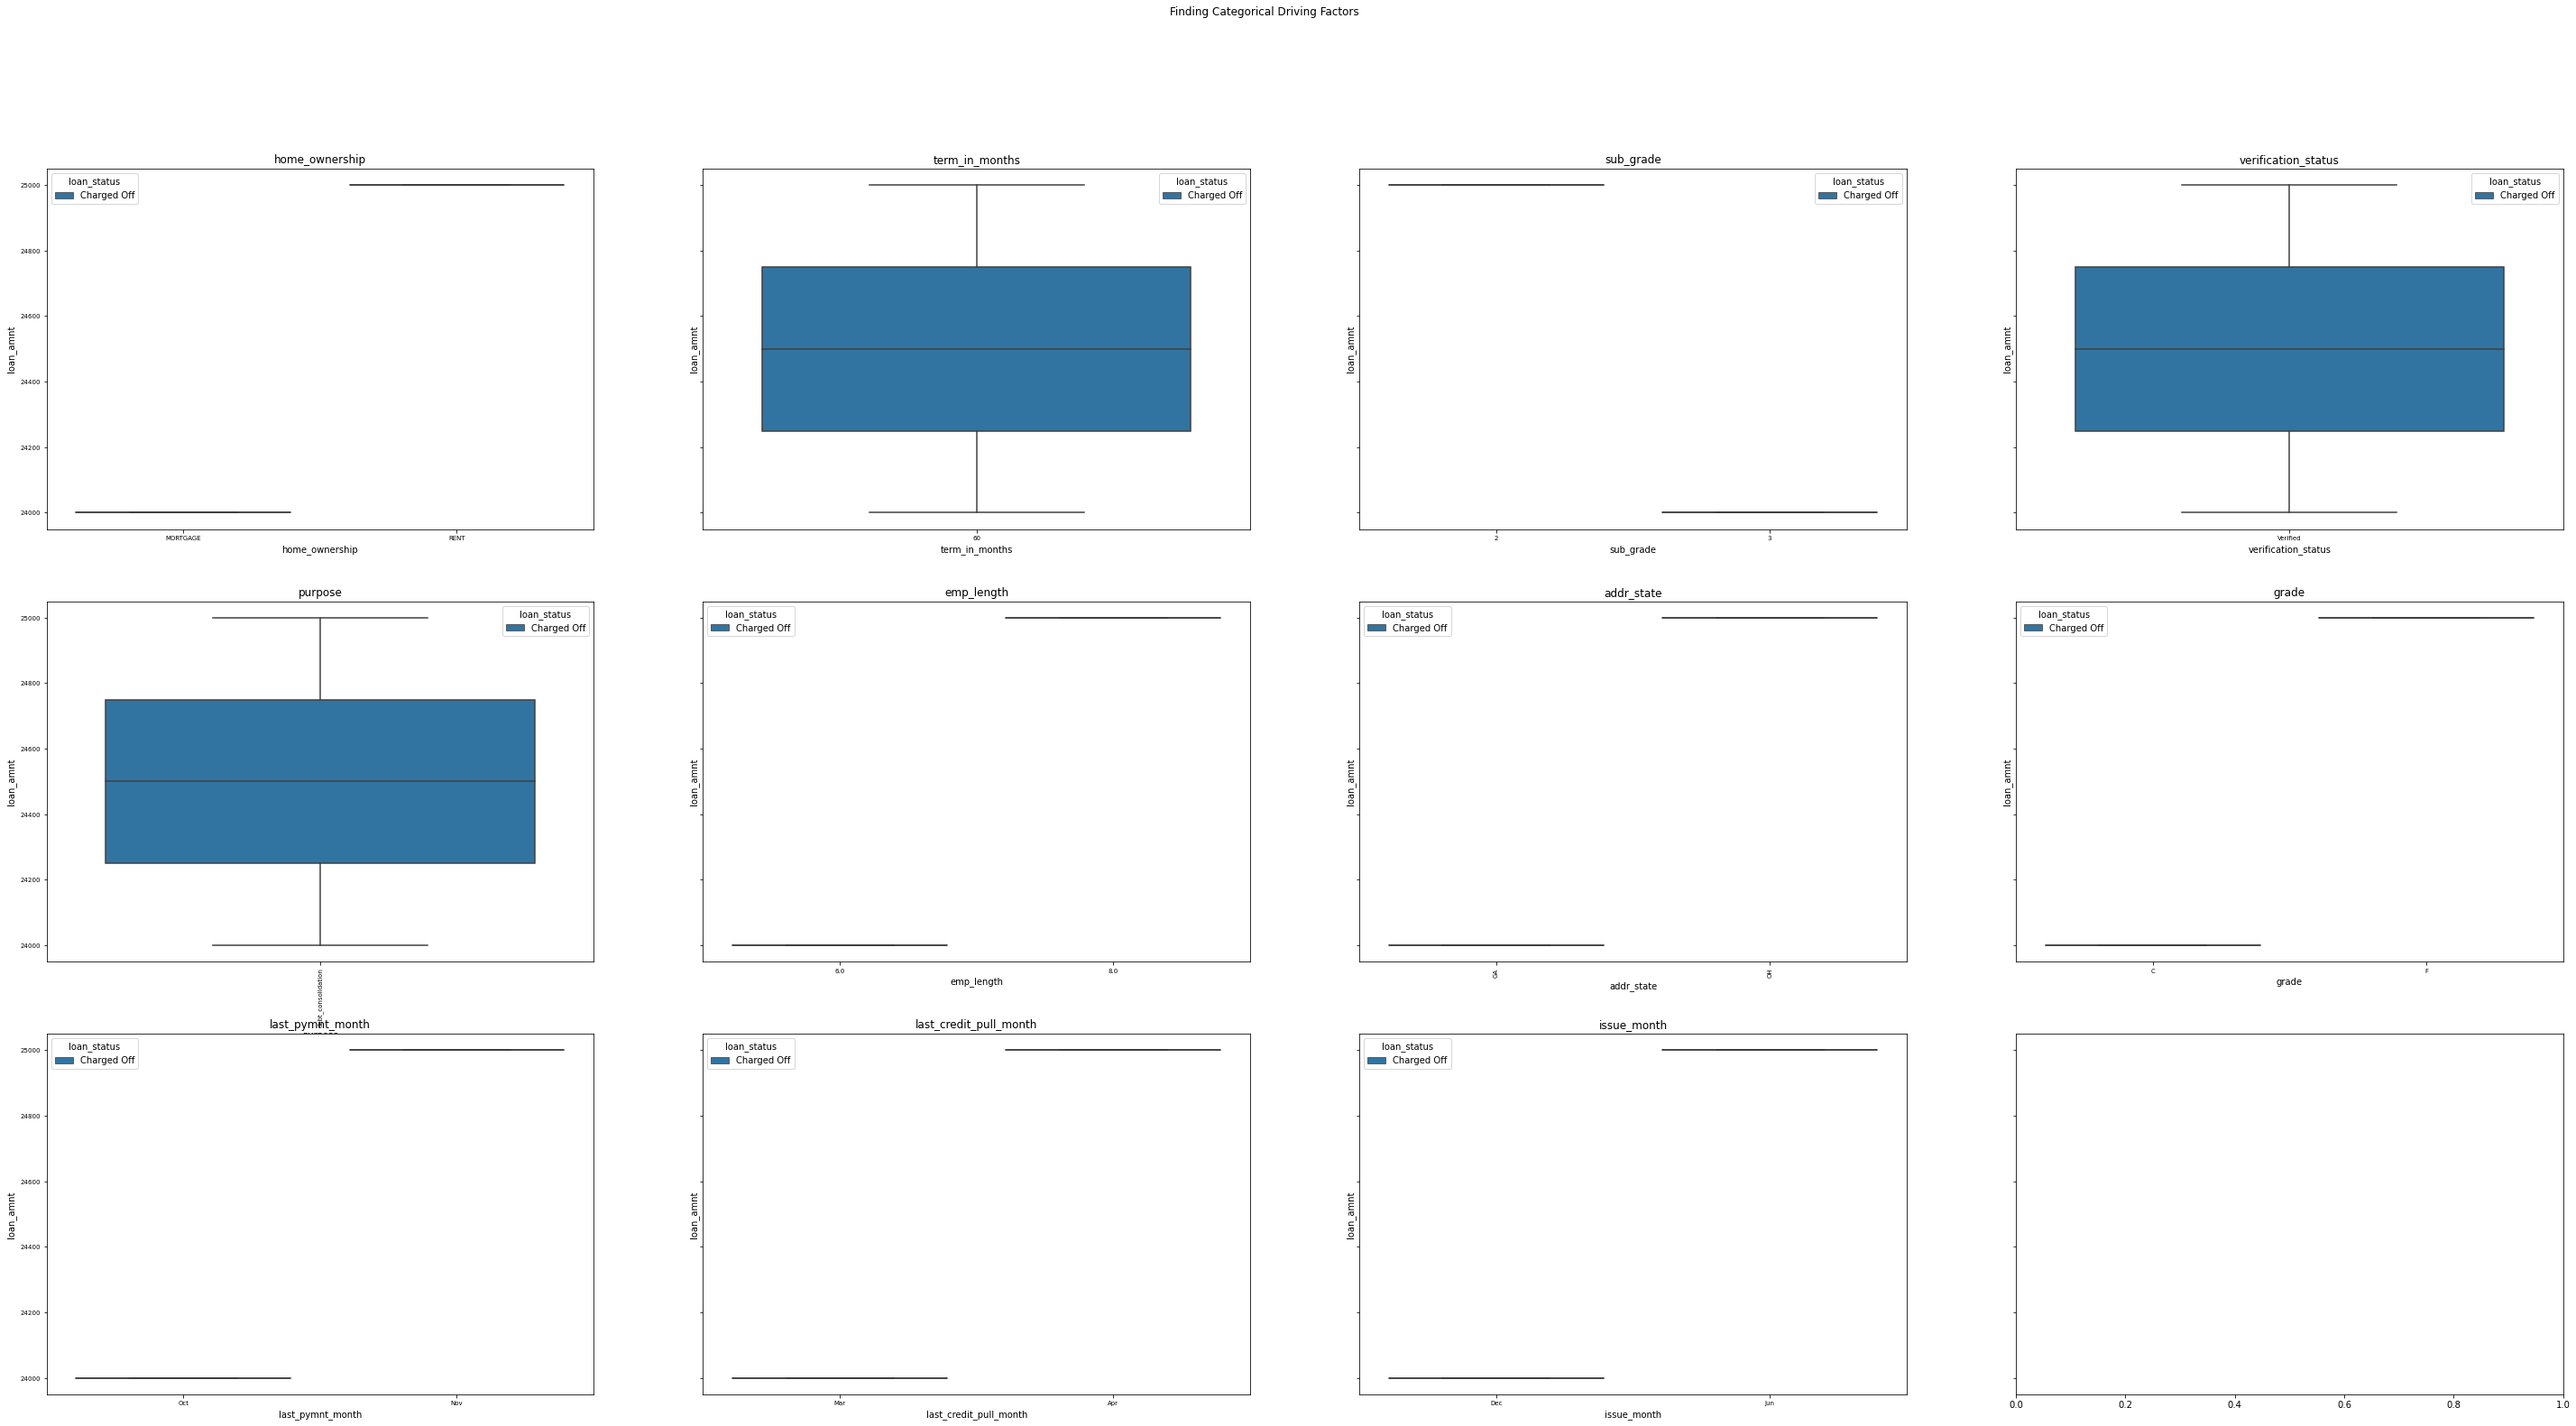

In [749]:
loan_analysis_20=loan_analysis[(loan_analysis.pub_rec_bankruptcies!=1)&(loan_analysis.loan_amnt>20000)&(loan_analysis.loan_amnt<=25000)]

loan_analysis_20=loan_analysis_20[(loan_analysis_20.inq_last_6mths.isin([1,2]))]
loan_analysis_20=loan_analysis_20[(loan_analysis_20.open_acc.isin([13]))]
loan_analysis_20=loan_analysis_20[(loan_analysis_20.last_credit_pull_month.isin(['Apr','Mar']))]
loan_analysis_20=loan_analysis_20[(loan_analysis_20.last_pymnt_month.isin(['Oct','Nov']))]
loan_analysis_20=loan_analysis_20[(loan_analysis_20.annual_income_cat.isin(['Above','High']))]
printDiffFullyPaidAndChargedOff(loan_analysis_20)
plotToChooseDrivingFactorDerivedCategorical(loan_analysis_20)
plotToChooseDrivingFactorDescrete(loan_analysis_20)
plotToChooseDrivingFactorCategorical(loan_analysis_20)

loan_analysis_20.loan_status.unique()


Total fully paid loan amount in slice 0
Total charged off loan amount in slice 62400
The difference between fully paid and charged off -62400




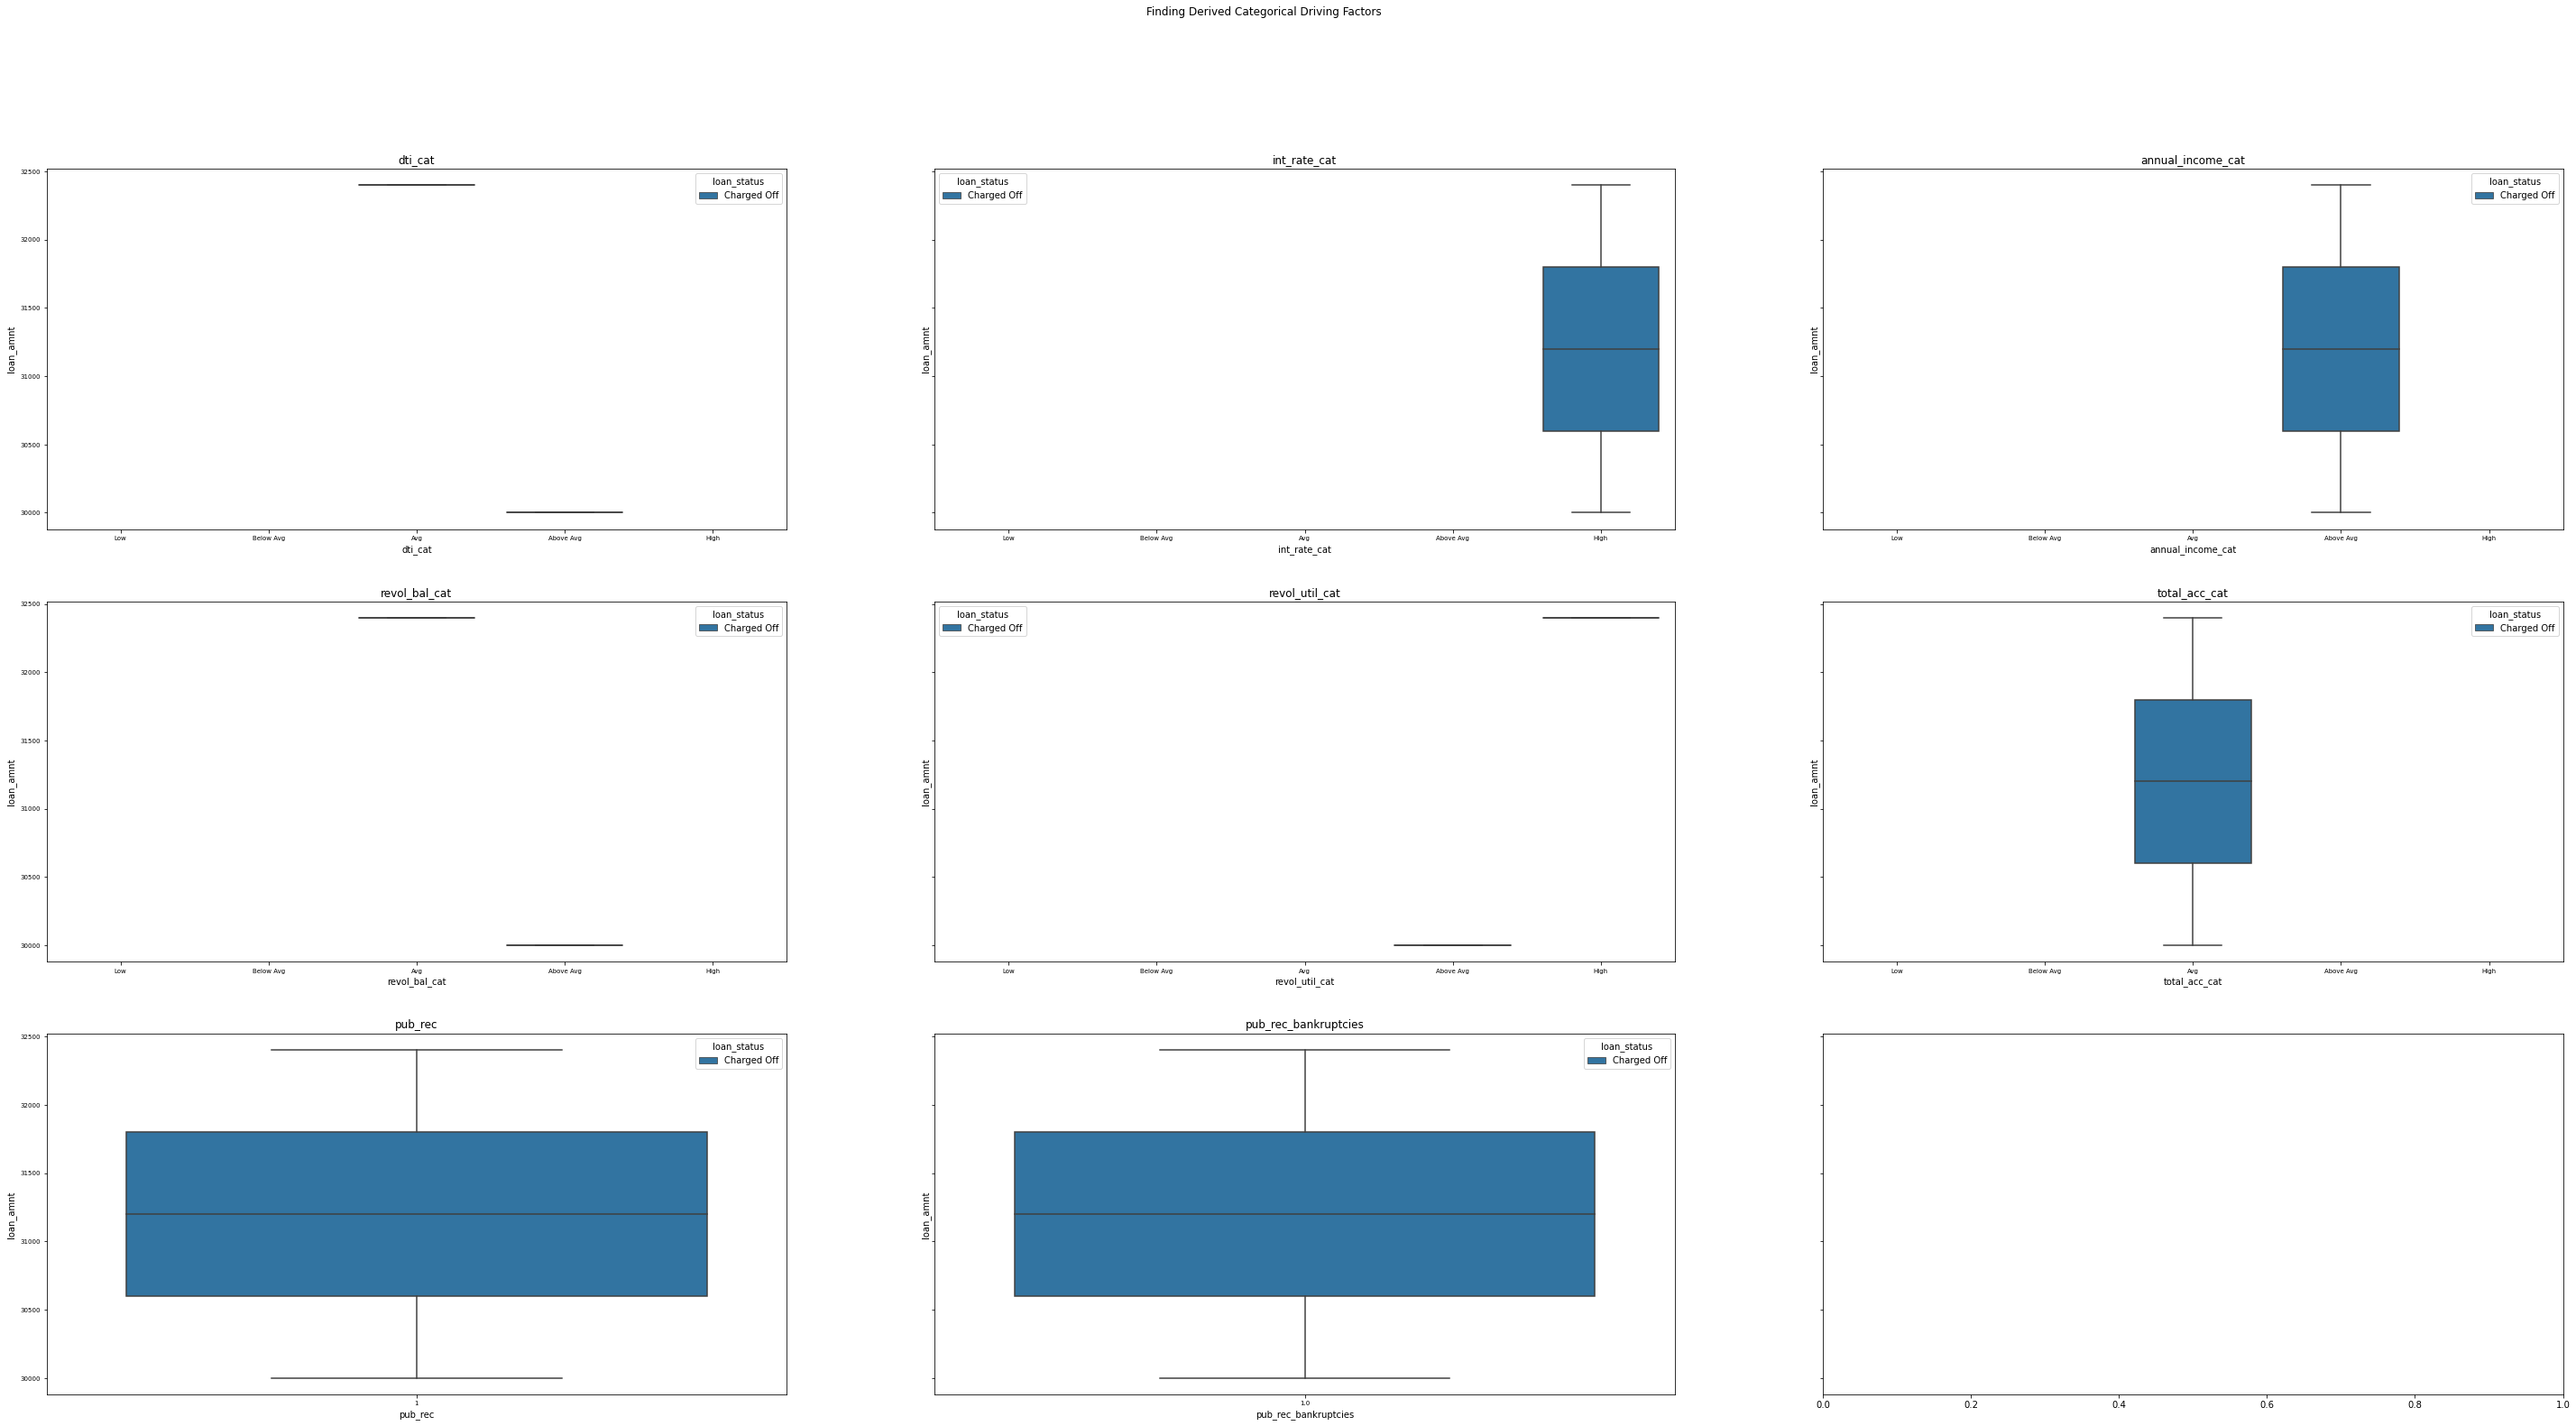

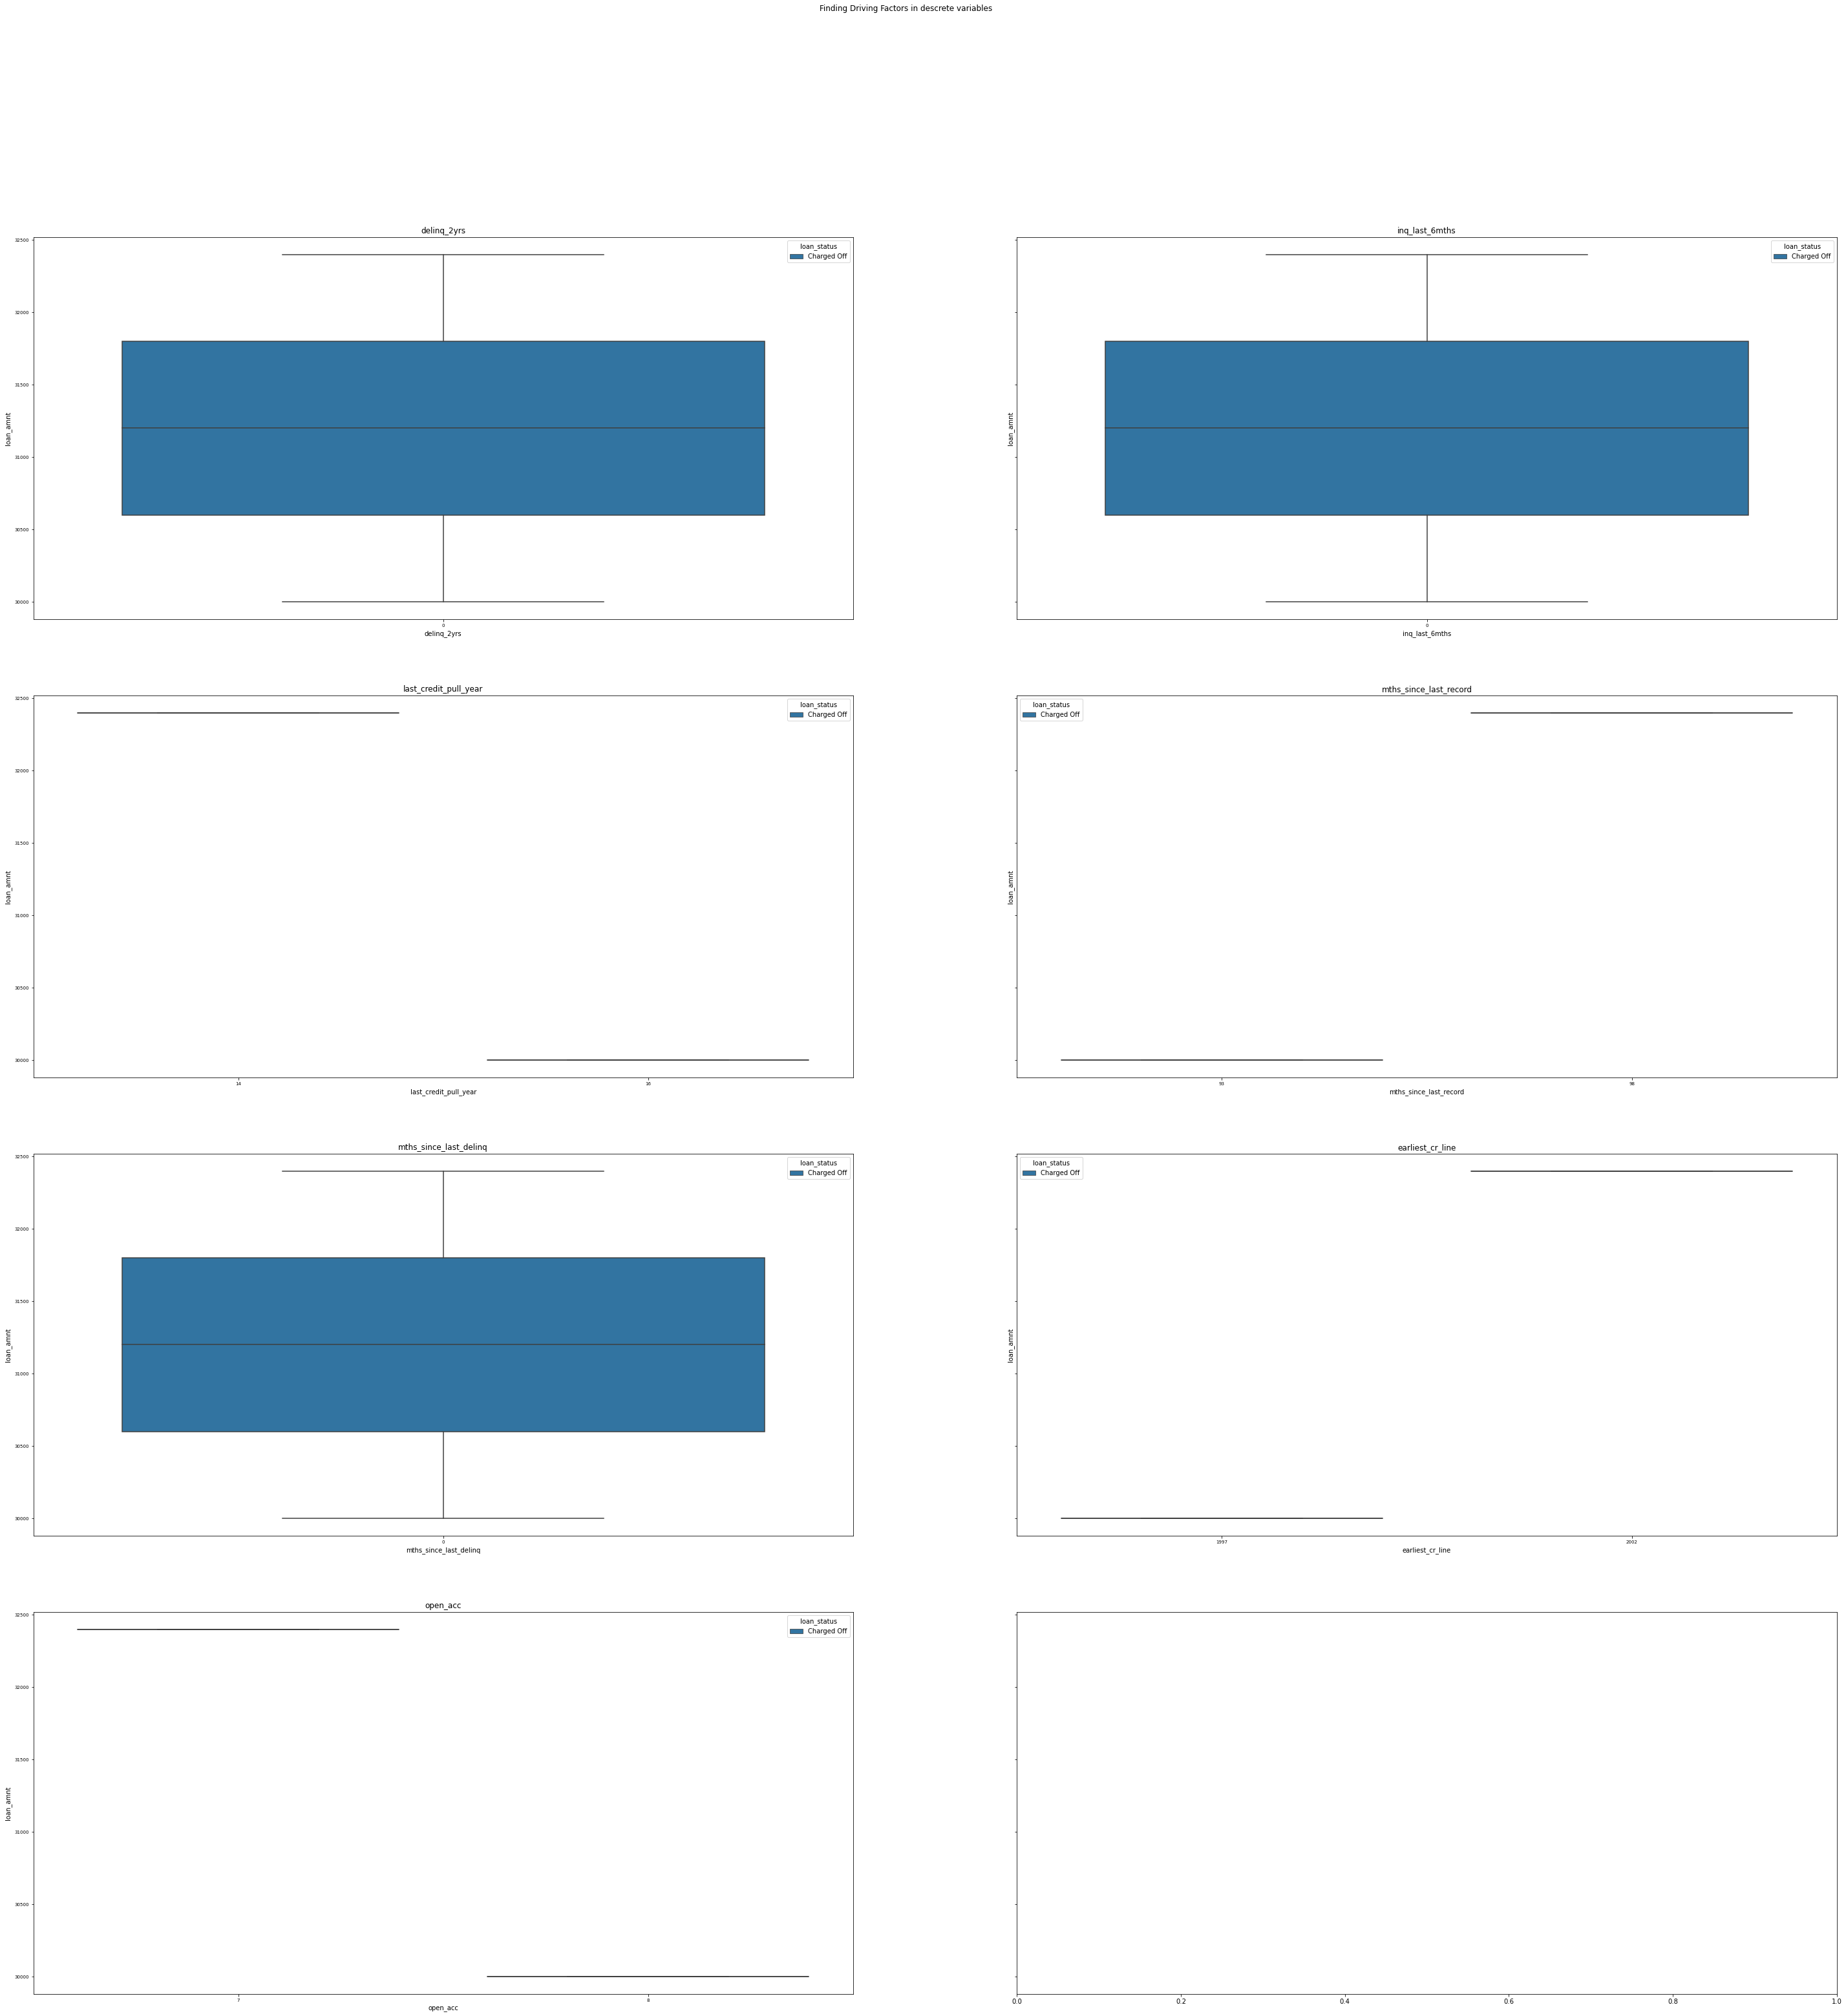

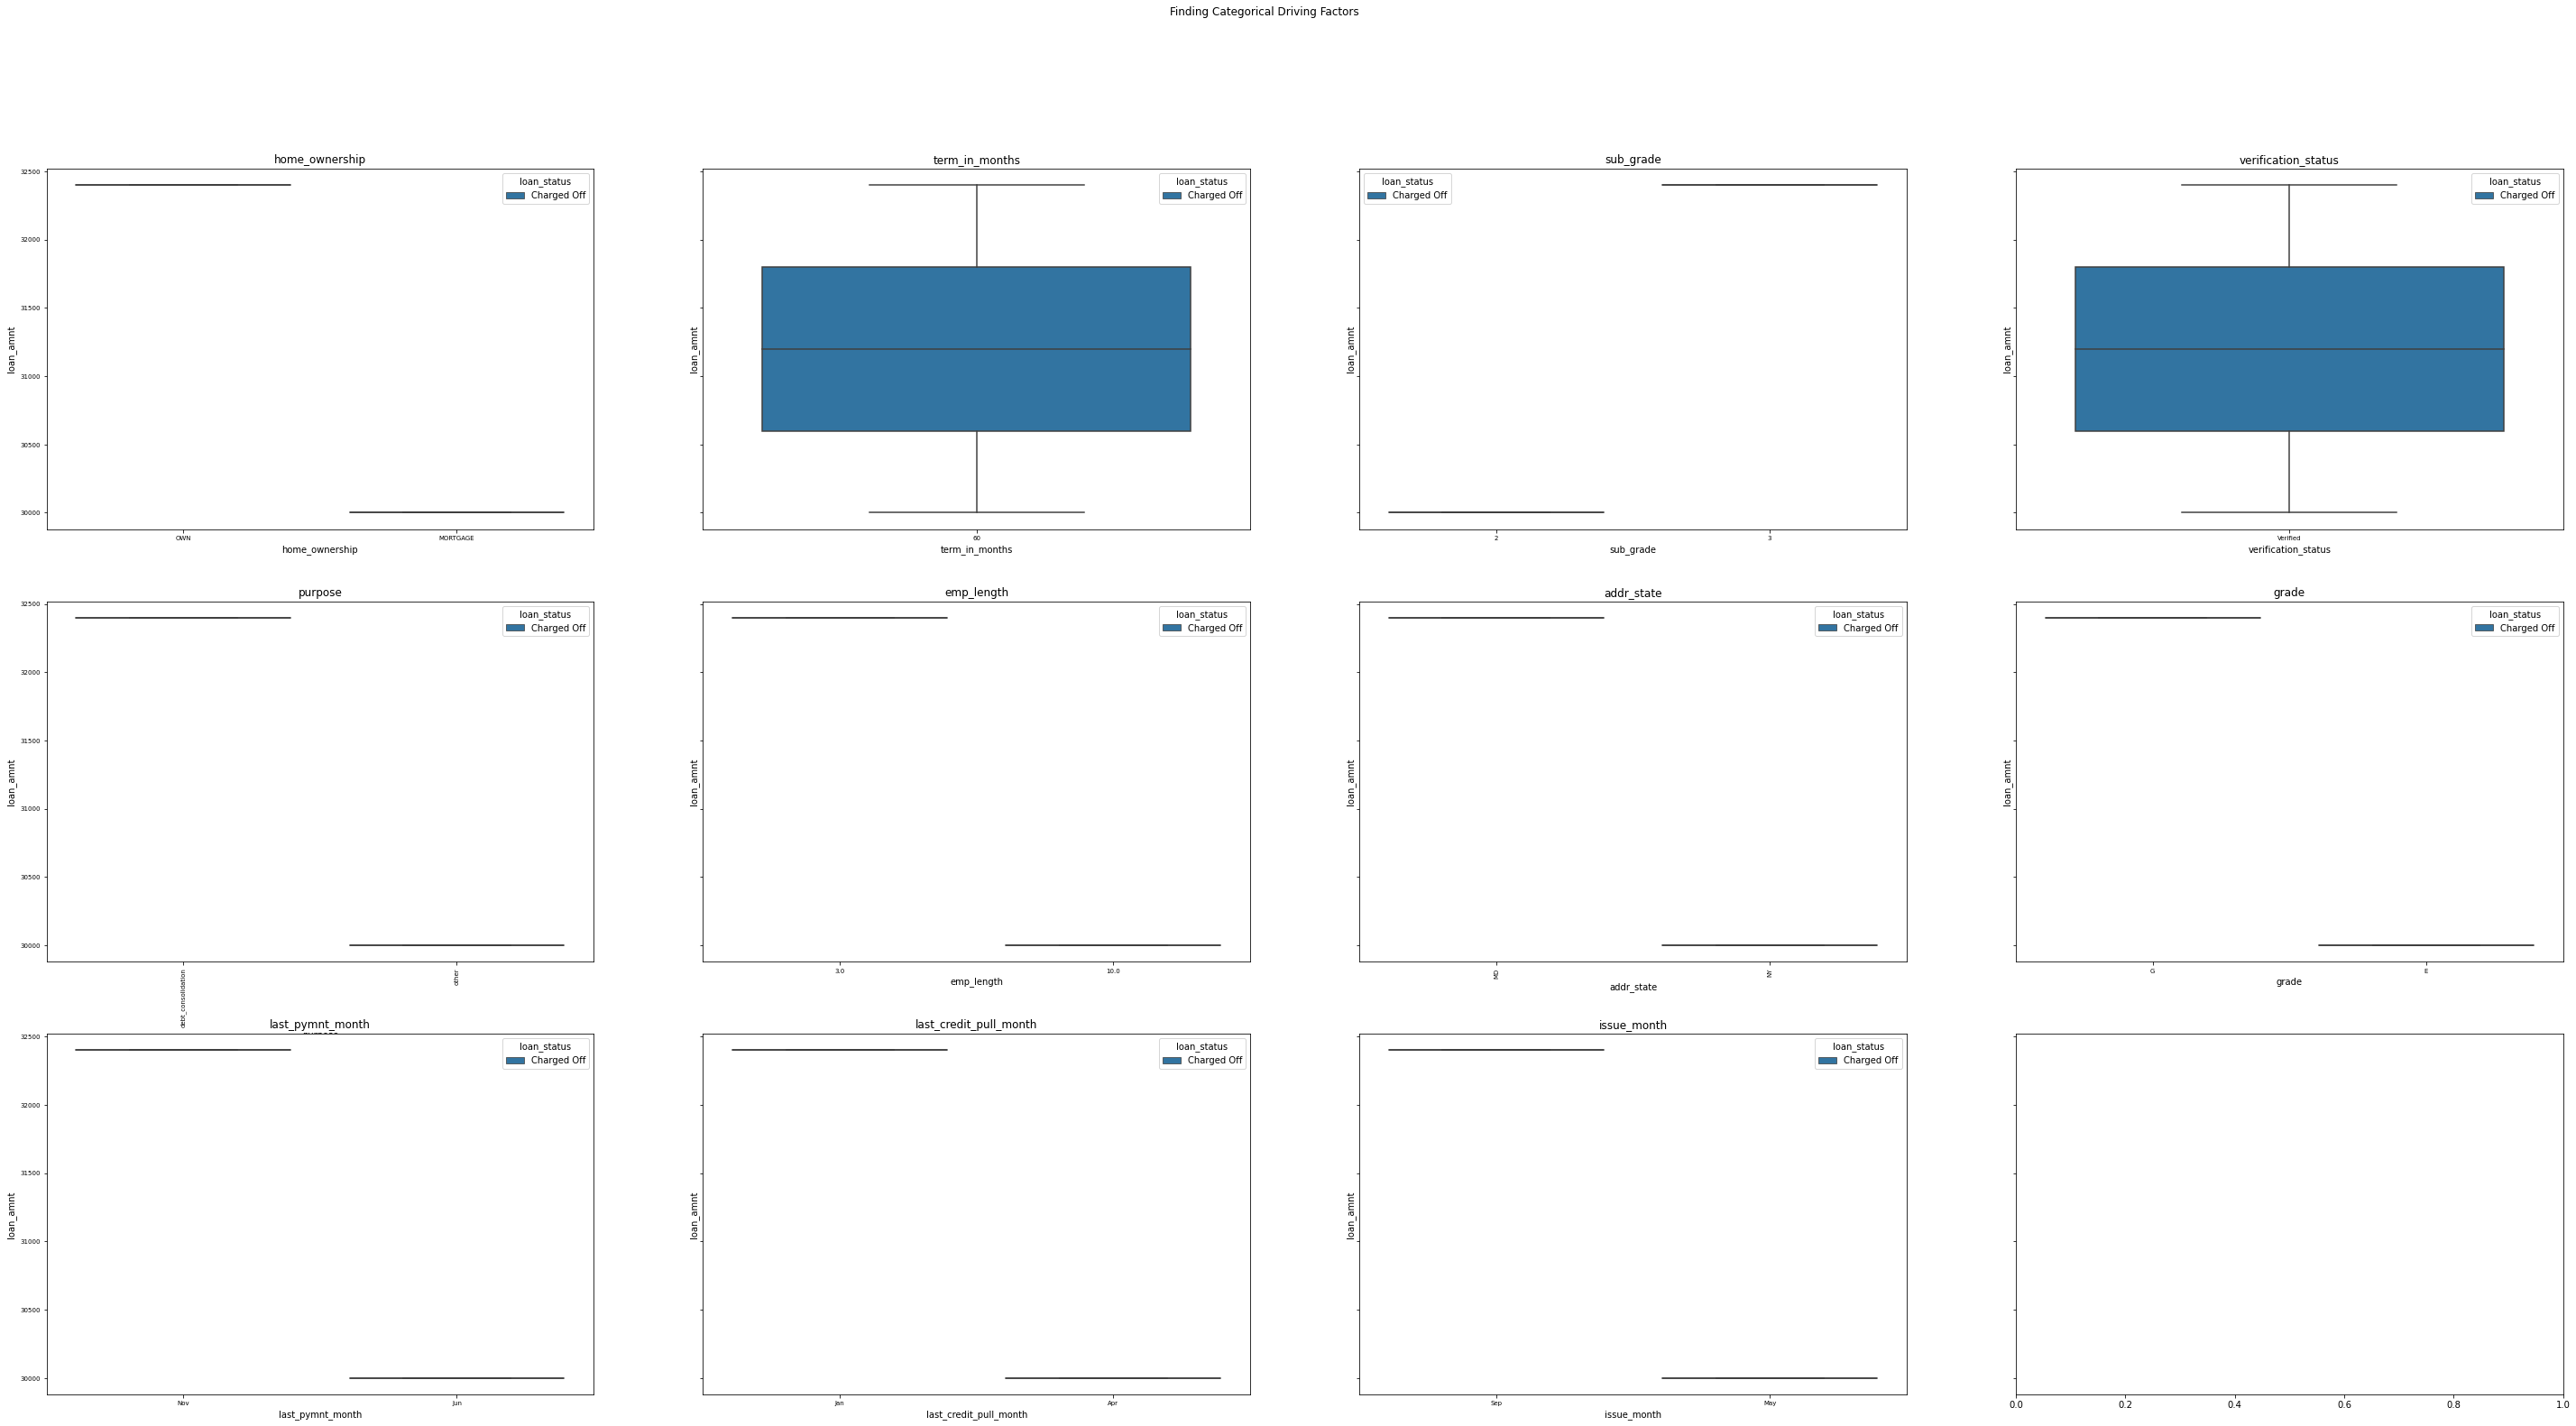

In [750]:
loan_analysis_b=loan_analysis[(loan_analysis.pub_rec_bankruptcies==1)&(loan_analysis.loan_amnt>25000)]
loan_analysis_b=loan_analysis_b[loan_analysis_b.annual_income_cat.isin(['Above Avg'])]
loan_analysis_b=loan_analysis_b[loan_analysis_b.total_acc_cat.isin(['Avg'])]
loan_analysis_b=loan_analysis_b[loan_analysis_b.inq_last_6mths.isin([0])]

printDiffFullyPaidAndChargedOff(loan_analysis_b)
plotToChooseDrivingFactorDerivedCategorical(loan_analysis_b)
plotToChooseDrivingFactorDescrete(loan_analysis_b)
plotToChooseDrivingFactorCategorical(loan_analysis_b)


In [751]:
#Proof on concept
#>25000
def Loan25condition(loanApplicant):
    loan_analysis_pub_bankr=(loanApplicant.pub_rec_bankruptcies==1)&(loanApplicant.loan_amnt>25000)
    loan_analysis_pub_bankr_inc=loanApplicant.annual_income_cat.isin(['Above Avg'])
    loan_analysis_pub_bankr_total=loanApplicant.total_acc_cat.isin(['Avg'])
    loan_analysis_pub_bankr_inq=loanApplicant.inq_last_6mths.isin([0])

    
    loan_25_condition=((loan_analysis.pub_rec_bankruptcies!=1)&(loanApplicant.loan_amnt>25000)&(loan_analysis.pub_rec_bankruptcies!=1))
    loan_25_inq=loanApplicant.inq_last_6mths>=5
    loan_25_revol_bal=(loanApplicant.revol_bal_cat!='Low')
    loan_25_dti=(loanApplicant.dti_cat!='Low')
    return (((loan_25_condition)&(loan_25_inq)&(loan_25_dti)&(loan_25_revol_bal))|(loan_analysis_pub_bankr&loan_analysis_pub_bankr_inc&loan_analysis_pub_bankr_total&loan_analysis_pub_bankr_inq))

#>20000
def Loan20condition(loanApplicant):
    loan_20_pub_br=(loanApplicant.pub_rec_bankruptcies==1)&(loanApplicant.loan_amnt>20000)&(loanApplicant.loan_amnt<=25000)
    loan_20_pub_br_dti=(~loanApplicant.dti_cat.isin(['Low','Avg']))
    loan_20_pub_br_int=(loanApplicant.int_rate_cat=='High')
    loan_20_pub_br_ai=(loanApplicant.annual_income_cat.isin(['Above Avg','High']))
    loan_20_pub_br_gr=(loanApplicant.grade.isin(['G']))

    loan_20_condition=(loan_analysis.pub_rec_bankruptcies!=1)&(loanApplicant.loan_amnt>20000)&(loanApplicant.loan_amnt<=25000)
    loan_inq_last_6mths=(loan_analysis_20.inq_last_6mths.isin([1,2]))
    loan_open_acc=(loan_analysis_20.open_acc.isin([13]))
    loan_last_credit_pull_month=(loan_analysis_20.last_credit_pull_month.isin(['Apr','Mar']))
    loan_last_pymnt_month=(loan_analysis_20.last_pymnt_month.isin(['Oct','Nov']))
    loan_annual_income_cat=(loan_analysis_20.annual_income_cat.isin(['Above','High']))

    return  (loan_20_pub_br &loan_20_pub_br_dti&loan_20_pub_br_int&loan_20_pub_br_ai&loan_20_pub_br_gr)|(loan_20_condition & loan_inq_last_6mths & loan_open_acc & loan_last_credit_pull_month & loan_last_pymnt_month & loan_annual_income_cat)

#>15000
def Loan15condition(loanApplicant):
    loan_15_condition=(loanApplicant.loan_amnt>=15000)&(loanApplicant.loan_amnt<=20000)
    loan_15_inq=loanApplicant.inq_last_6mths>=5
    loan_15_revol_bal=(loanApplicant.revol_bal_cat=='High')
    loan_15_dti=(loanApplicant.dti_cat.isin(['Below Avg','Low']))
    loan_15_open_acc=(loanApplicant.open_acc>10)
    
    return (loan_15_condition)&(loan_15_inq)&(loan_15_dti)&(loan_15_open_acc)&(loan_15_revol_bal)

# These conditions are derived from the driving factors. This does not find all the charged off loans. But this proves the concept. Hence stopping here
loan_subset = loan_for_analysis[Loan15condition(loan_for_analysis)|Loan20condition(loan_for_analysis)|Loan25condition(loan_for_analysis)]
print(loan_subset.loan_status.unique())
print(loan_subset.loan_amnt.sum())


256100